In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('default')
import yfinance as yf
from datetime import datetime

In [2]:
# Define the ticker symbol
ticker_symbol = 'BBTN.JK'

# Fetch the data
bbtn_data = yf.download(ticker_symbol, start='2019-03-11', end='2024-03-11')
bbtn_data

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-11  2016.675171  2034.443237  1998.907104  2016.675171  1807.873047   
2019-03-12  2034.443237  2061.095215  2007.791138  2016.675171  1807.873047   
2019-03-13  2007.791138  2034.443237  1998.907104  2034.443237  1823.801392   
2019-03-14  2061.095215  2141.051514  2052.211182  2141.051514  1919.371582   
2019-03-15  2132.167480  2194.355713  2114.399414  2167.703613  1943.264160   
...                 ...          ...          ...          ...          ...   
2024-03-04  1445.000000  1445.000000  1400.000000  1410.000000  1358.463867   
2024-03-05  1410.000000  1420.000000  1345.000000  1350.000000  1300.656860   
2024-03-06  1360.000000  1390.000000  1355.000000  1385.000000  1334.377563   
2024-03-07  1390.000000  1390.000000  1365.000000  1365.000000  1315.108643   
2024-03-08  1370.000000  1385.000000  1360.000000  1380.000000  1329.560303   

               Volume  
Date                   
2019-03-11    8784075  
2019-03-12   19089193  
2019-03-13    4239178  
2019-03-14   33951815  
2019-03-15   36828662  
...               ...  
2024-03-04   42691800  
2024-03-05  111696100  
2024-03-06   41312300  
2024-03-07   27127200  
2024-03-08   31098900  

[1229 rows x 6 columns]

In [3]:
# drop 0 value in Volume
bbtn_data = bbtn_data[bbtn_data.Volume != 0]

#Data telah bersih
a = bbtn_data[bbtn_data.Volume == 0]
len(a)

bbtn_data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-11  2016.675171  2034.443237  1998.907104  2016.675171  1807.873047   
2019-03-12  2034.443237  2061.095215  2007.791138  2016.675171  1807.873047   
2019-03-13  2007.791138  2034.443237  1998.907104  2034.443237  1823.801392   
2019-03-14  2061.095215  2141.051514  2052.211182  2141.051514  1919.371582   
2019-03-15  2132.167480  2194.355713  2114.399414  2167.703613  1943.264160   
...                 ...          ...          ...          ...          ...   
2024-03-04  1445.000000  1445.000000  1400.000000  1410.000000  1358.463867   
2024-03-05  1410.000000  1420.000000  1345.000000  1350.000000  1300.656860   
2024-03-06  1360.000000  1390.000000  1355.000000  1385.000000  1334.377563   
2024-03-07  1390.000000  1390.000000  1365.000000  1365.000000  1315.108643   
2024-03-08  1370.000000  1385.000000  1360.000000  1380.000000  1329.560303   

               Volume  
Date                   
2019-03-11    8784075  
2019-03-12   19089193  
2019-03-13    4239178  
2019-03-14   33951815  
2019-03-15   36828662  
...               ...  
2024-03-04   42691800  
2024-03-05  111696100  
2024-03-06   41312300  
2024-03-07   27127200  
2024-03-08   31098900  

[1219 rows x 6 columns]

In [5]:
# Create a new dataframe with only the Close column 
data = bbtn_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.90) # 90% 10%

# Split dataset into training and testing sets
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

# Normalize data
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_train_data

array([[0.76441105],
       [0.76441105],
       [0.77443611],
       ...,
       [0.33183904],
       [0.32901795],
       [0.32619686]])

In [6]:
print(scaled_train_data.shape)
print(len(scaled_train_data))

(1098, 1)
1098


In [7]:
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# Function to train LSTM model and return predictions and RMSE
def train_lstm_model(x_train, y_train, x_test, actual):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(Dense(25, activation='linear'))  # Adding a linear activation function
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, actual),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1, mode='min')], verbose= 1, shuffle=False)

    # Get the models predicted price values from train
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) # unscaling the values

    # Get the root mean squared error (RMSE)
    rmse= np.sqrt(np.mean(((predictions - actual)**2)))
    mape= np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return predictions, rmse, mape

In [8]:
# Create empty lists to store results
all_predictions = []
all_rmse = []
all_mape = []

# Perform 50 runs of LSTM
for i in range(50):
    print(f"Run: {i+1}")
    # Create the scaled training data set with window size = 100
    train_data = scaled_train_data
    #split the data into x_train and y_train dataset
    x_train = []
    y_train = []
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i])
        y_train.append(train_data[i])
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(len(x_train))
    print(len(y_train))
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the scaled testing data set
    testing_data = dataset[training_data_len-100:]
    test_data = scaler.transform(testing_data.reshape(-1,1))
    # Create the dataset x_test and y_test
    x_test = []
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    actual = dataset[training_data_len:]
    # Train LSTM model and return predictions, RMSE, and MAPE
    predictions, rmse, mape = train_lstm_model(x_train, y_train, x_test, actual)
    
    # Append predictions and RMSE to lists
    all_predictions.append(predictions)
    all_rmse.append(rmse)
    all_mape.append(mape)

Run: 1
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1643 - val_loss: 1653659.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0108 - val_loss: 1653700.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0091 - val_loss: 1653713.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0070 - val_loss: 1653748.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0067 - val_loss: 1653725.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653721.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 2
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1059 - val_loss: 1653678.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 1653695.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0093 - val_loss: 1653713.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0078 - val_loss: 1653715.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061 - val_loss: 1653735.6250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0067 - val_loss: 1653713.6250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 3
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0769 - val_loss: 1653620.3750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 1653678.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 1653730.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0064 - val_loss: 1653713.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0061 - val_loss: 1653704.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0058 - val_loss: 1653682.5000
Epoch 6: early stopping
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17d56e340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1281 - val_loss: 1653686.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0114 - val_loss: 1653686.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0077 - val_loss: 1653724.8750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 1653702.6250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653710.6250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 1653716.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Run: 5
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1048 - val_loss: 1653644.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 1653677.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0077 - val_loss: 1653722.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060 - val_loss: 1653718.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 1653723.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0056 - val_loss: 1653707.1250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 6
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1147 - val_loss: 1653626.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0101 - val_loss: 1653706.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - val_loss: 1653705.3750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0069 - val_loss: 1653722.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0060 - val_loss: 1653723.6250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0051 - val_loss: 1653728.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 7
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0796 - val_loss: 1653623.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0074 - val_loss: 1653709.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0072 - val_loss: 1653710.8750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055 - val_loss: 1653723.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0051 - val_loss: 1653730.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0050 - val_loss: 1653707.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 8
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1248 - val_loss: 1653644.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 1653689.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 1653702.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0063 - val_loss: 1653730.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653729.1250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 1653712.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 9
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1167 - val_loss: 1653665.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0089 - val_loss: 1653685.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 1653716.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 1653728.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061 - val_loss: 1653725.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057 - val_loss: 1653708.6250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 10
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1562 - val_loss: 1653680.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0143 - val_loss: 1653691.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0097 - val_loss: 1653743.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0073 - val_loss: 1653725.8750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0064 - val_loss: 1653718.8750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 1653718.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 11
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1292 - val_loss: 1653655.8750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0120 - val_loss: 1653723.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0093 - val_loss: 1653719.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0059 - val_loss: 1653713.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0067 - val_loss: 1653713.3750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 1653709.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 12
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1234 - val_loss: 1653659.8750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0102 - val_loss: 1653699.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0085 - val_loss: 1653717.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 1653705.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 1653708.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653719.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 13
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0843 - val_loss: 1653600.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 1653733.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0093 - val_loss: 1653709.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 1653729.8750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653736.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0058 - val_loss: 1653711.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 14
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1324 - val_loss: 1653636.8750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 1653679.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0084 - val_loss: 1653699.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0062 - val_loss: 1653715.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0054 - val_loss: 1653736.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0063 - val_loss: 1653703.8750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 15
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1425 - val_loss: 1653651.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0108 - val_loss: 1653711.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0099 - val_loss: 1653717.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065 - val_loss: 1653736.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061 - val_loss: 1653741.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 1653723.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 16
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1296 - val_loss: 1653632.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 1653687.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0082 - val_loss: 1653719.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 1653720.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0062 - val_loss: 1653732.8750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0056 - val_loss: 1653714.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Run: 17
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1177 - val_loss: 1653659.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0093 - val_loss: 1653676.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 1653718.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 1653720.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050 - val_loss: 1653708.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0053 - val_loss: 1653726.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 18
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0853 - val_loss: 1653611.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0075 - val_loss: 1653691.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 1653725.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0064 - val_loss: 1653726.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653720.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0047 - val_loss: 1653713.1250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 19
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0895 - val_loss: 1653590.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 1653739.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0081 - val_loss: 1653694.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0064 - val_loss: 1653727.3750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653719.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060 - val_loss: 1653728.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 20
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0970 - val_loss: 1653651.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 1653689.6250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 1653713.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0068 - val_loss: 1653731.3750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0062 - val_loss: 1653705.3750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0059 - val_loss: 1653726.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 21
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1461 - val_loss: 1653699.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0117 - val_loss: 1653690.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 1653687.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653720.3750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 1653730.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653715.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 1653716.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057 - val_loss: 1653717.1250
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 22
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1298 - val_loss: 1653672.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0102 - val_loss: 1653692.1250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0072 - val_loss: 1653688.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 1653726.8750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0055 - val_loss: 1653712.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0053 - val_loss: 1653722.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 23
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0932 - val_loss: 1653610.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 1653694.1250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0081 - val_loss: 1653734.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0072 - val_loss: 1653724.8750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0056 - val_loss: 1653704.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 1653717.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 24
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1360 - val_loss: 1653658.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0093 - val_loss: 1653679.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0072 - val_loss: 1653739.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0067 - val_loss: 1653717.6250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0065 - val_loss: 1653724.6250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0058 - val_loss: 1653710.3750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run: 25
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1774 - val_loss: 1653715.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0144 - val_loss: 1653712.6250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 1653704.3750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0065 - val_loss: 1653707.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653746.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0064 - val_loss: 1653725.5000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0051 - val_loss: 1653711.7500
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0046 - val_loss: 1653721.2500
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Run: 26
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1303 - val_loss: 1653606.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - val_loss: 1653718.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - val_loss: 1653712.3750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0071 - val_loss: 1653730.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0064 - val_loss: 1653710.3750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0064 - val_loss: 1653715.3750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 27
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0804 - val_loss: 1653617.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 1653697.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 1653707.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653725.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 1653731.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 1653705.1250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 28
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1350 - val_loss: 1653666.8750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 1653676.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0079 - val_loss: 1653711.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0076 - val_loss: 1653741.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0063 - val_loss: 1653709.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 1653713.1250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 29
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1845 - val_loss: 1653692.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0116 - val_loss: 1653678.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 1653726.3750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0079 - val_loss: 1653715.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0070 - val_loss: 1653744.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0065 - val_loss: 1653710.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - val_loss: 1653710.5000
Epoch 7: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 30
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0809 - val_loss: 1653605.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0070 - val_loss: 1653718.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0086 - val_loss: 1653722.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0067 - val_loss: 1653717.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0053 - val_loss: 1653737.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 1653711.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 31
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1257 - val_loss: 1653651.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0096 - val_loss: 1653697.1250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0075 - val_loss: 1653711.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653705.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653709.3750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057 - val_loss: 1653736.8750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Run: 32
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1041 - val_loss: 1653650.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0088 - val_loss: 1653688.6250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078 - val_loss: 1653718.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0070 - val_loss: 1653730.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0068 - val_loss: 1653705.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653744.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 33
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1773 - val_loss: 1653697.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0143 - val_loss: 1653704.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 1653712.8750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0072 - val_loss: 1653712.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653732.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 1653725.6250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 34
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1153 - val_loss: 1653643.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0106 - val_loss: 1653703.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 1653710.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0077 - val_loss: 1653718.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057 - val_loss: 1653719.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 1653716.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 35
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1482 - val_loss: 1653661.6250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0105 - val_loss: 1653701.6250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 1653719.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0069 - val_loss: 1653717.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065 - val_loss: 1653751.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071 - val_loss: 1653723.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 36
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1077 - val_loss: 1653612.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0089 - val_loss: 1653705.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 1653702.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653725.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0055 - val_loss: 1653712.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 1653712.3750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 37
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1388 - val_loss: 1653722.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0109 - val_loss: 1653703.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088 - val_loss: 1653712.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0070 - val_loss: 1653739.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069 - val_loss: 1653714.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 1653751.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653710.0000
Epoch 7: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 38
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1455 - val_loss: 1653616.8750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0100 - val_loss: 1653683.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 1653715.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0072 - val_loss: 1653726.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 1653687.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0055 - val_loss: 1653738.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 39
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1394 - val_loss: 1653663.3750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0129 - val_loss: 1653736.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 1653738.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653718.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653703.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 1653718.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 40
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1712 - val_loss: 1653717.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0125 - val_loss: 1653718.1250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0093 - val_loss: 1653713.2500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0074 - val_loss: 1653729.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653709.8750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0062 - val_loss: 1653715.3750
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 1653721.8750
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050 - val_loss: 1653698.7500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 1653717.6250
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 1653688.5000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0045 - val_loss: 1653695.0000
Epoch 12

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1820 - val_loss: 1653696.1250
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0131 - val_loss: 1653704.2500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0084 - val_loss: 1653716.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0068 - val_loss: 1653723.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0066 - val_loss: 1653716.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 1653723.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 42
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1367 - val_loss: 1653619.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0089 - val_loss: 1653696.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 1653721.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0063 - val_loss: 1653717.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653726.8750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 1653723.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 43
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0450 - val_loss: 1653669.7500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069 - val_loss: 1653734.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 1653723.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 1653726.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 1653688.8750
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 1653691.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 44
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1045 - val_loss: 1653610.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090 - val_loss: 1653701.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 1653709.8750
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 1653704.1250
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061 - val_loss: 1653729.6250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0058 - val_loss: 1653725.1250
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 45
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1408 - val_loss: 1653667.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0105 - val_loss: 1653689.6250
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0081 - val_loss: 1653717.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061 - val_loss: 1653722.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653726.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 1653696.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 46
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0962 - val_loss: 1653660.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 1653700.3750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 1653712.7500
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 1653744.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0066 - val_loss: 1653693.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0062 - val_loss: 1653725.7500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 47
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0748 - val_loss: 1653579.3750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0075 - val_loss: 1653706.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0068 - val_loss: 1653729.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0064 - val_loss: 1653726.2500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065 - val_loss: 1653707.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052 - val_loss: 1653717.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 48
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0829 - val_loss: 1653612.2500
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0086 - val_loss: 1653687.7500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 1653719.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653737.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 1653725.7500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 1653724.2500
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 49
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1460 - val_loss: 1653687.3750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0119 - val_loss: 1653698.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0082 - val_loss: 1653688.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - val_loss: 1653727.3750
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 1653716.2500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0053 - val_loss: 1653722.5000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 50
998
998
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1260 - val_loss: 1653675.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0109 - val_loss: 1653694.8750
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 1653692.1250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0059 - val_loss: 1653711.7500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 1653726.1250
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050 - val_loss: 1653714.3750
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [11]:
# Create DataFrame to store results
results_df = pd.DataFrame()

# Add predictions to DataFrame
for i in range(50):
    col_name = f'Prediction_{i+1}'
    predictions_series = pd.Series(all_predictions[i].reshape(-1), name=col_name)
    results_df = pd.concat([results_df, predictions_series], axis=1)

# Add RMSE & MAPE as a row to DataFrame if the lengths match
results_df.loc['RMSE'] = all_rmse
results_df.loc['MAPE'] = all_mape

# Calculate average of predictions from Prediction_1 to Prediction_50
results_df['Average_Prediction'] = results_df.iloc[:, :].mean(axis=1)

# Calculate standard deviation of predictions from Prediction_1 to Prediction_50
results_df['Prediction_Std'] = results_df.iloc[:, :-1].std(axis=1)

# Print results DataFrame
print(results_df)

      Prediction_1  Prediction_2  Prediction_3  Prediction_4  Prediction_5  \
0      1238.907715   1244.779175   1262.648438   1241.177246   1248.072388   
1      1236.855103   1242.701294   1260.698975   1239.300903   1246.052856   
2      1234.586304   1240.361816   1258.488403   1237.151978   1243.726196   
3      1231.859863   1237.511963   1255.740967   1234.458740   1240.833618   
4      1228.942261   1234.469849   1252.772583   1231.542725   1237.755127   
...            ...           ...           ...           ...           ...   
118    1400.623535   1406.475220   1429.948120   1399.093140   1410.082275   
119    1397.656616   1402.909668   1425.137817   1394.153687   1405.892944   
120    1392.798218   1397.610840   1418.449585   1387.609863   1400.092651   
RMSE     50.960926     47.836989     44.046456     48.112360     45.635360   
MAPE      2.722022      2.565174      2.667341      2.515942      2.482701   

      Prediction_6  Prediction_7  Prediction_8  Prediction_9  P

In [12]:
# Save DataFrame to CSV with header
results_df.to_csv('BBTNLSTMFullW100.csv', header=True)

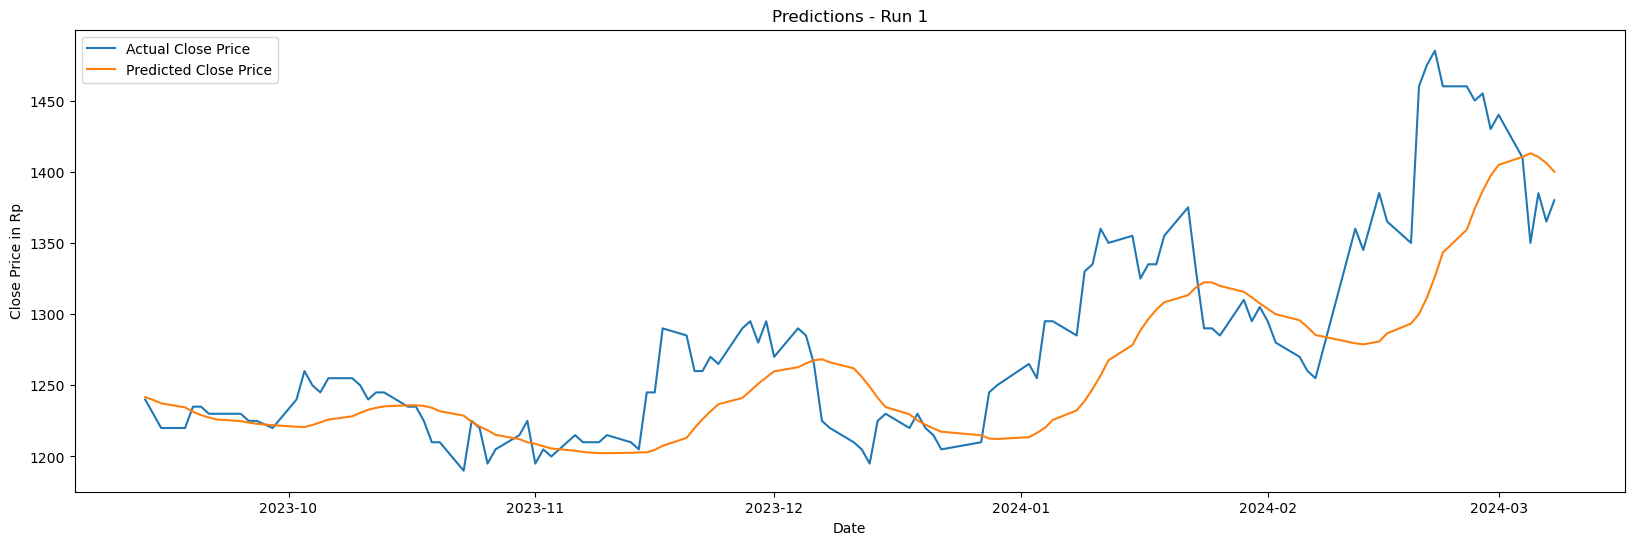

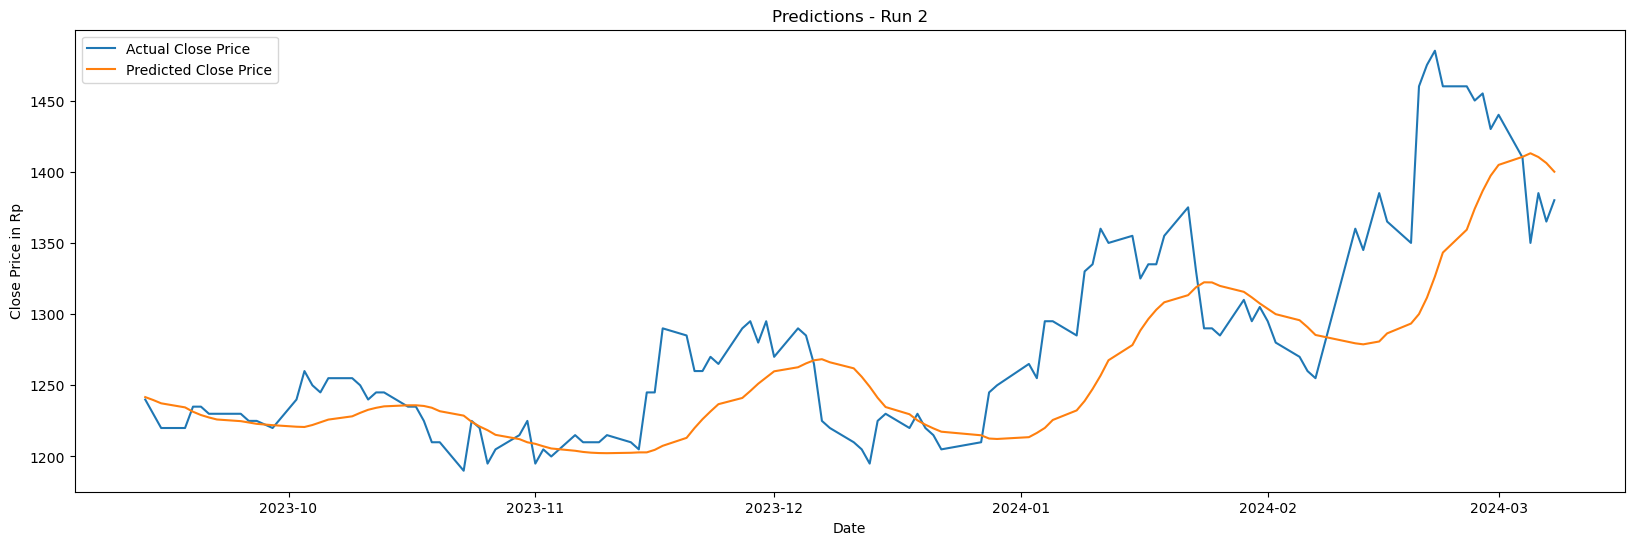

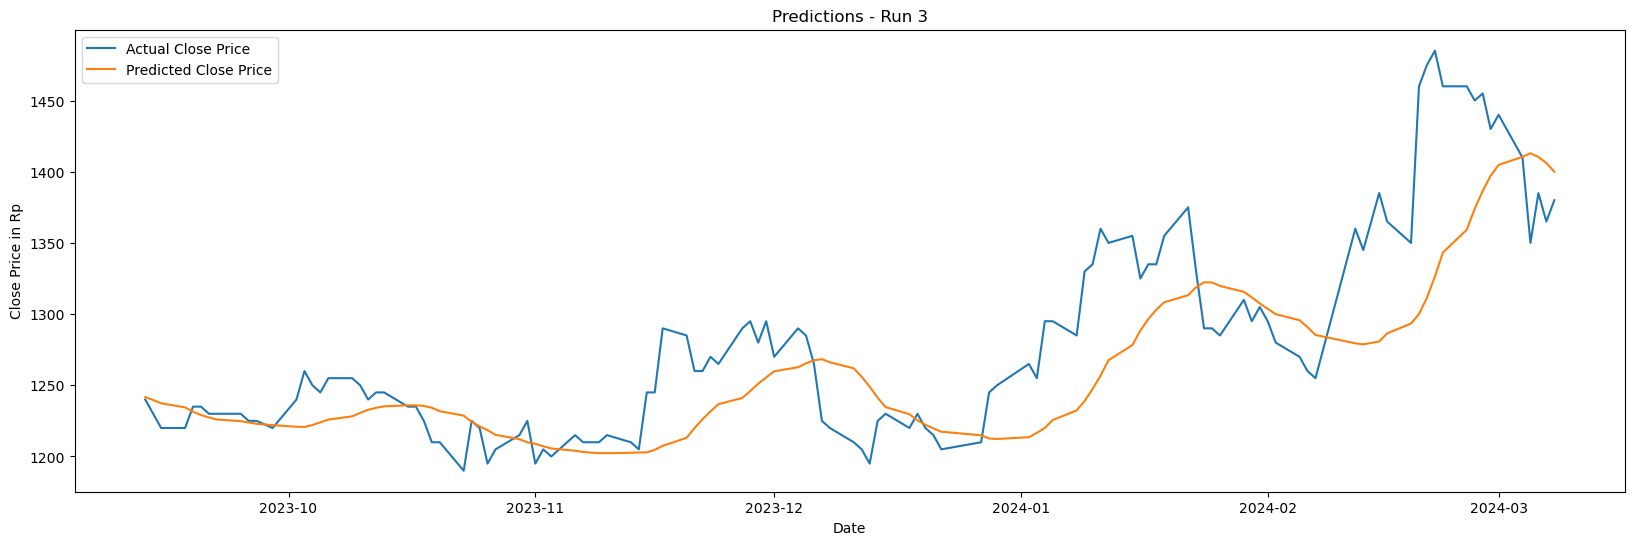

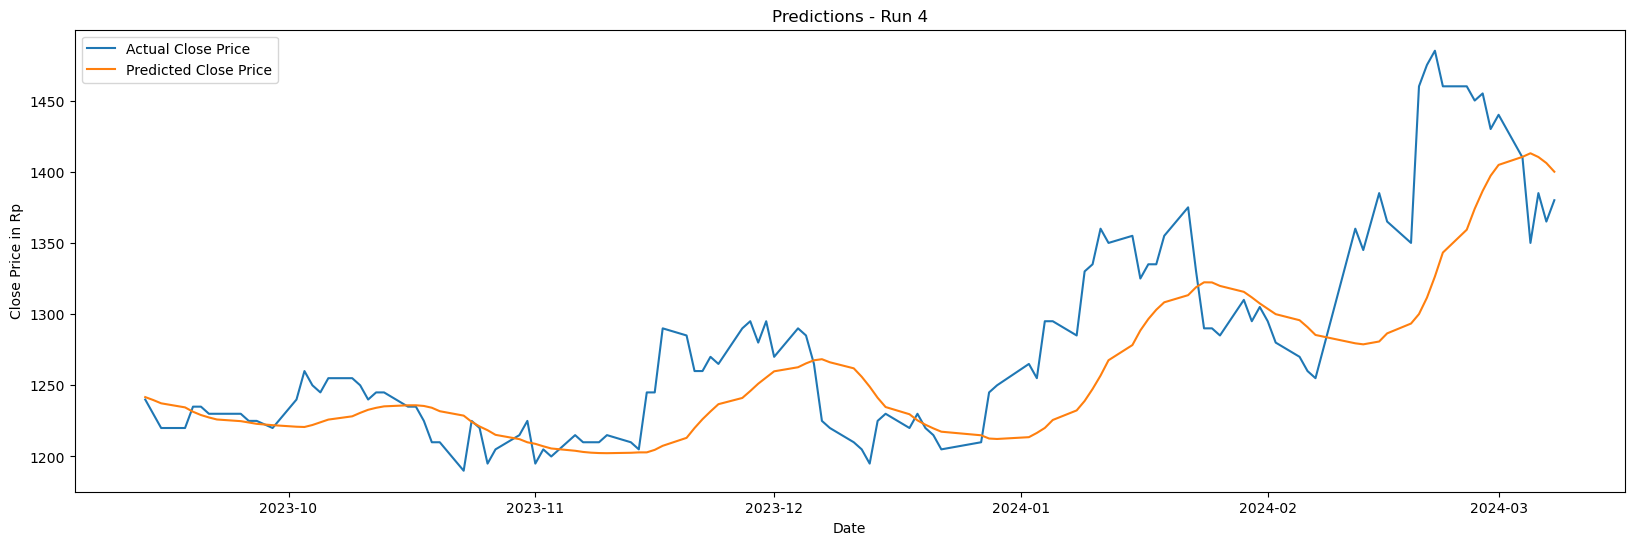

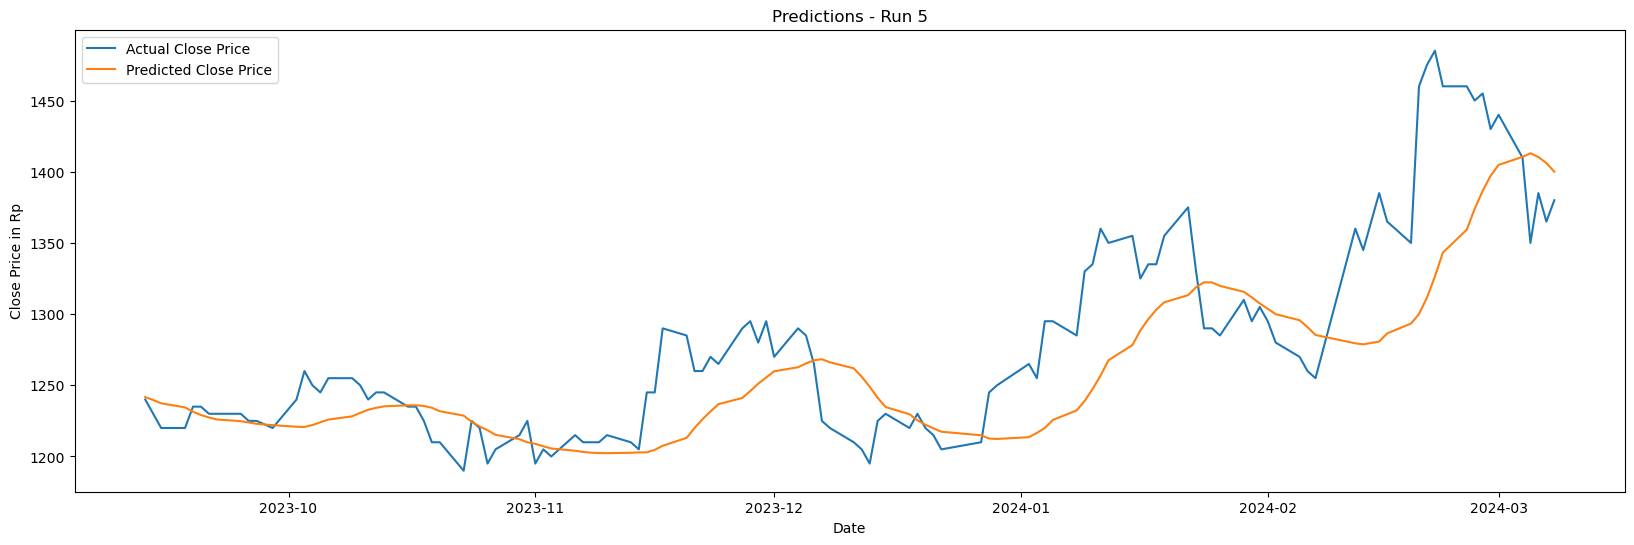

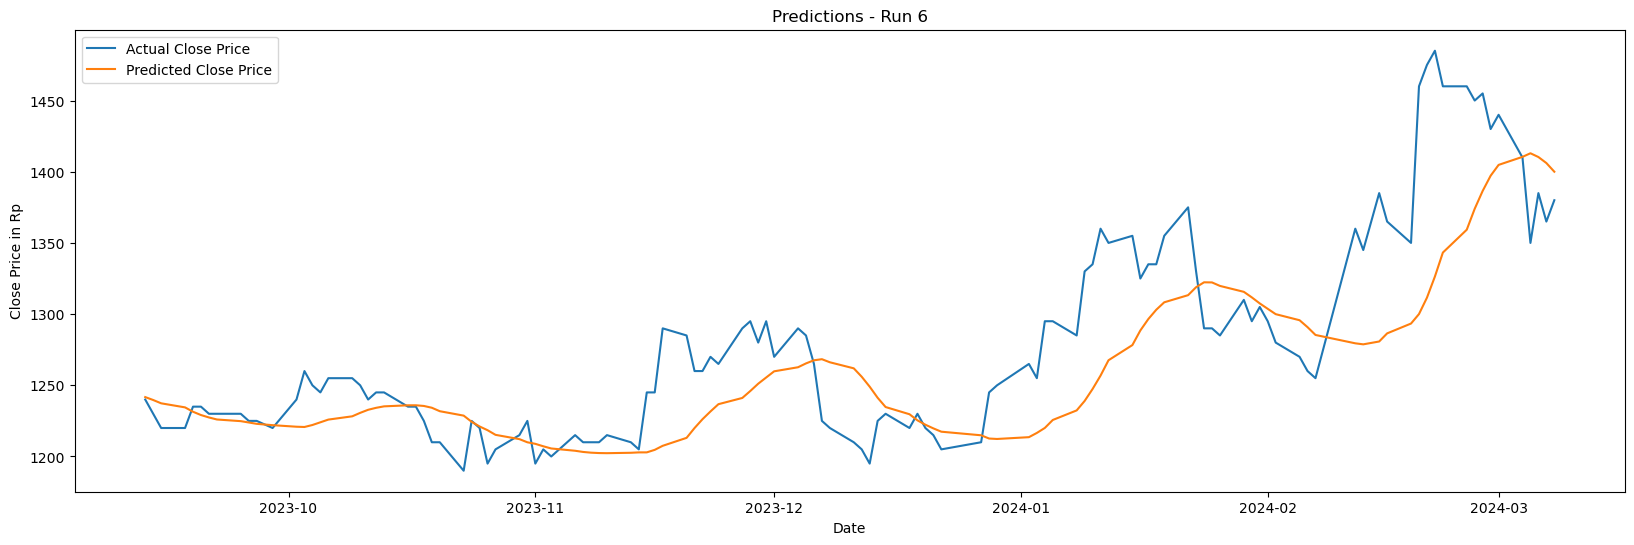

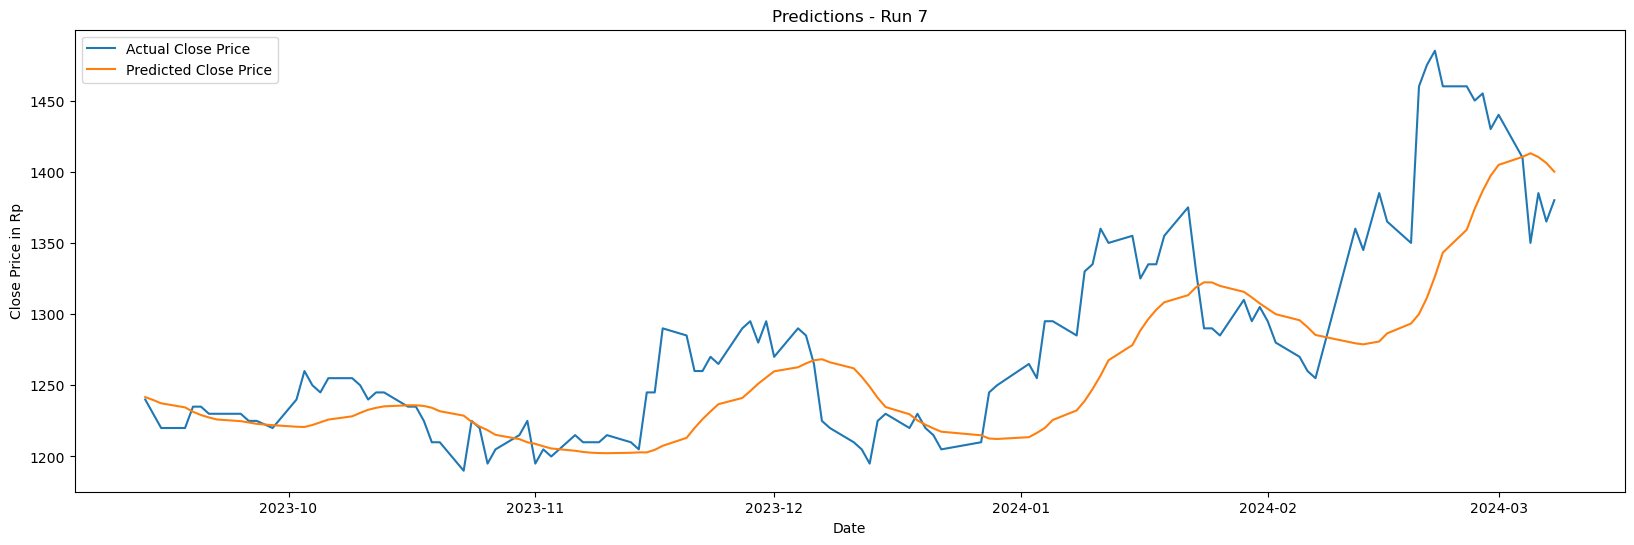

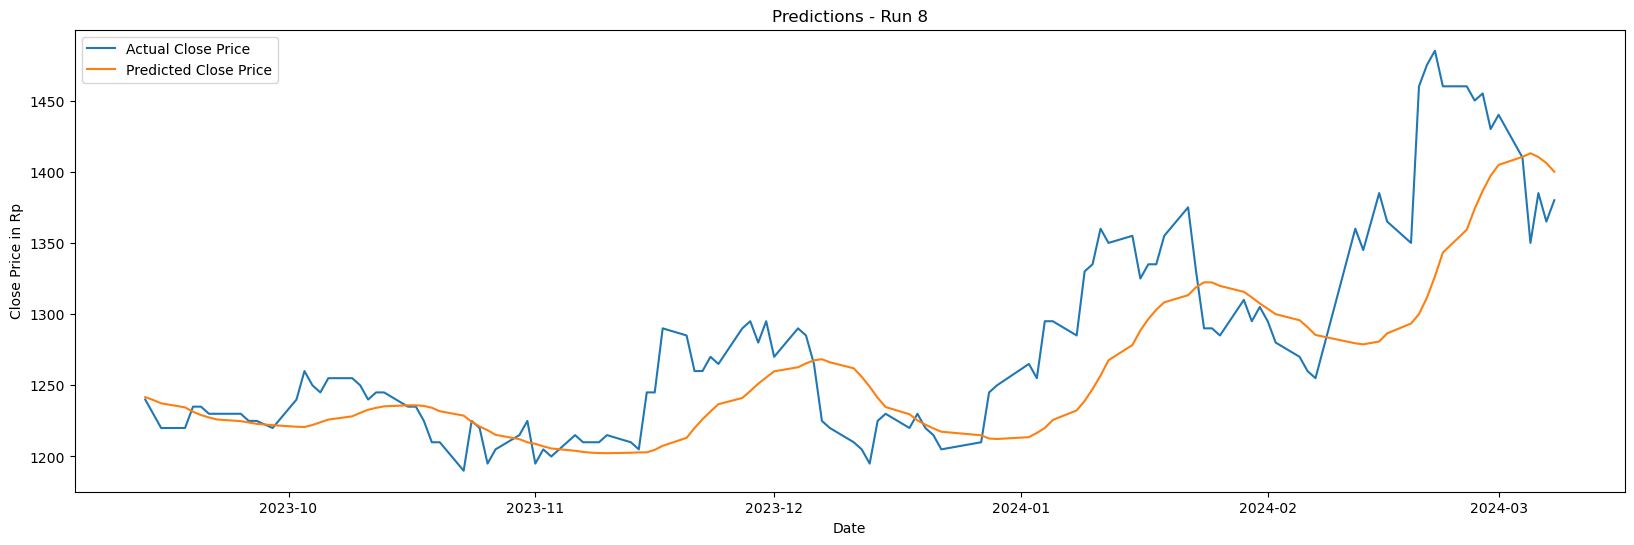

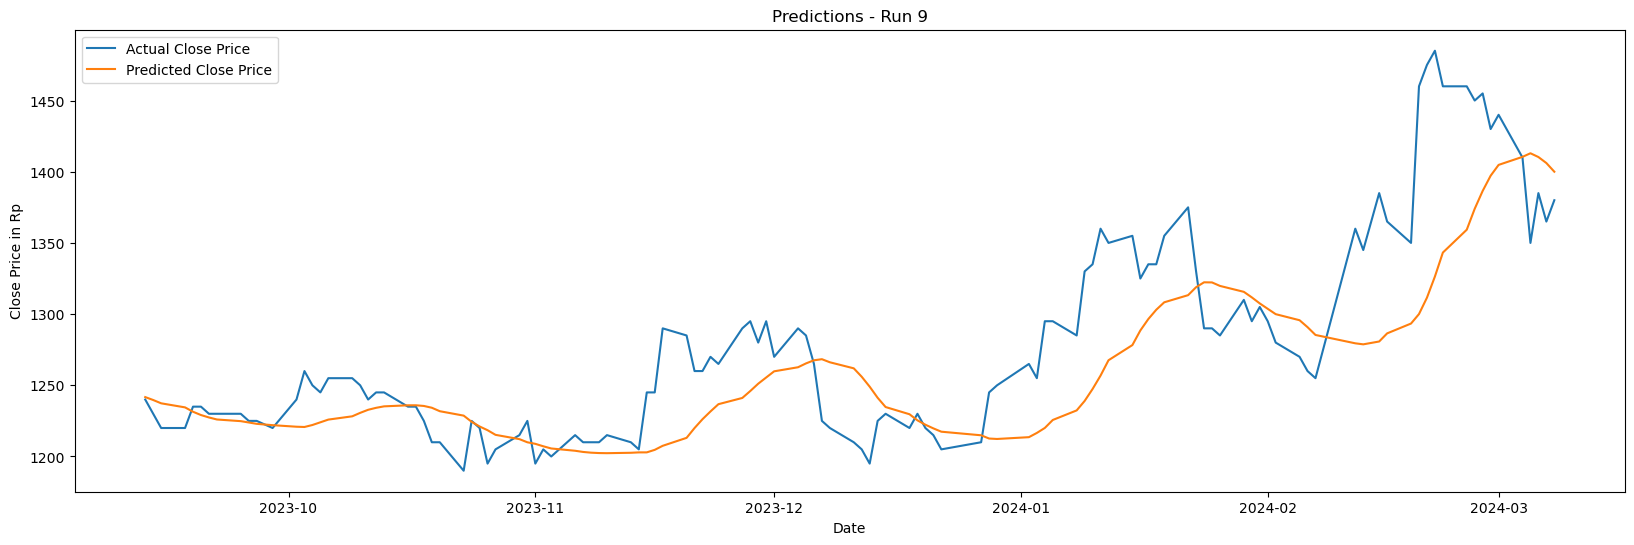

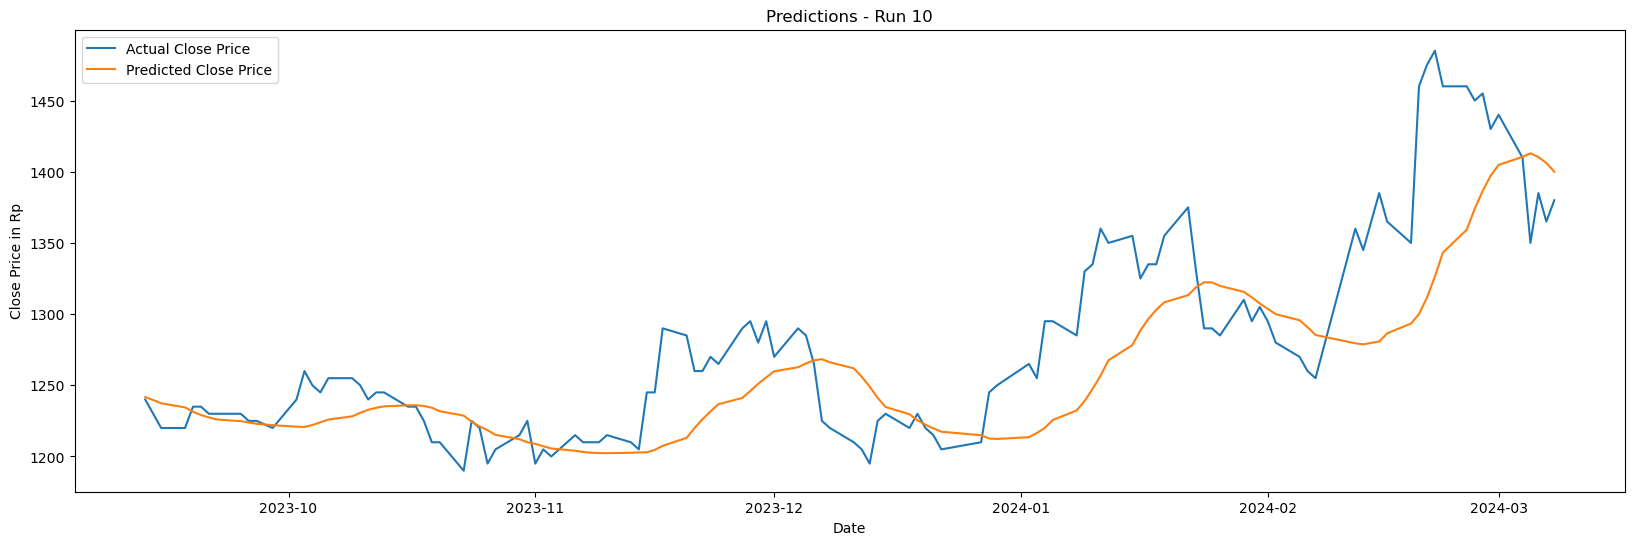

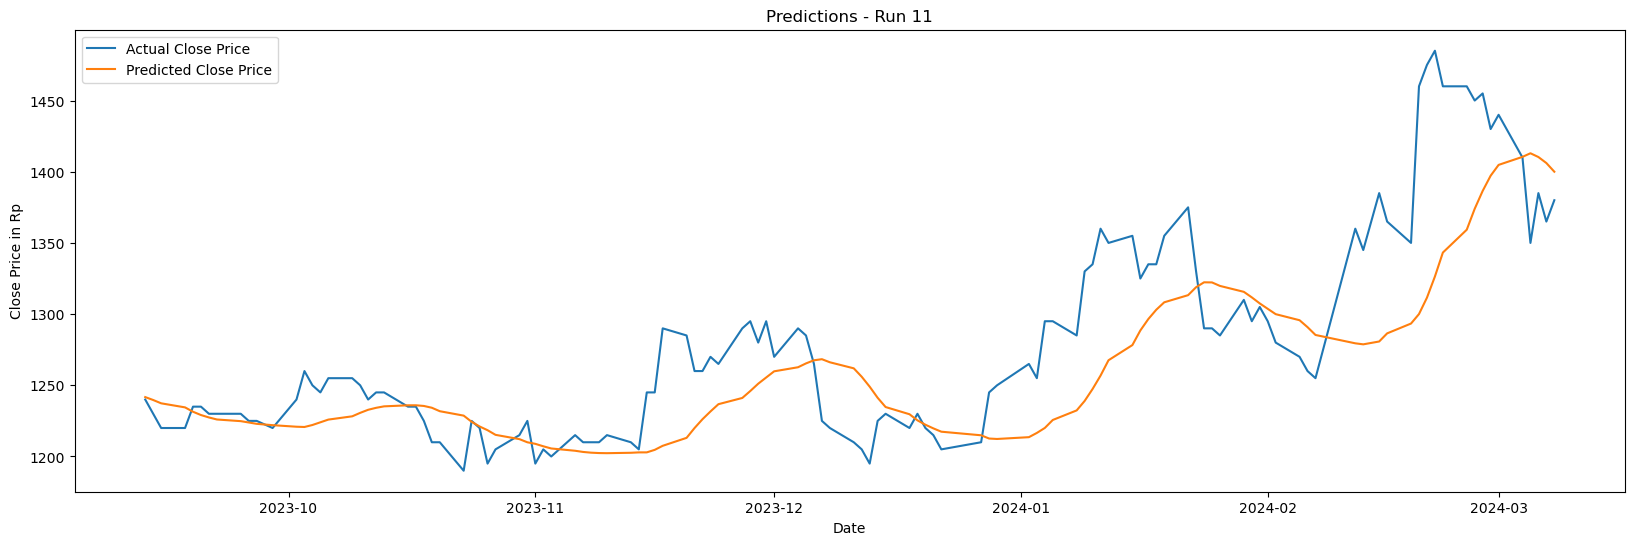

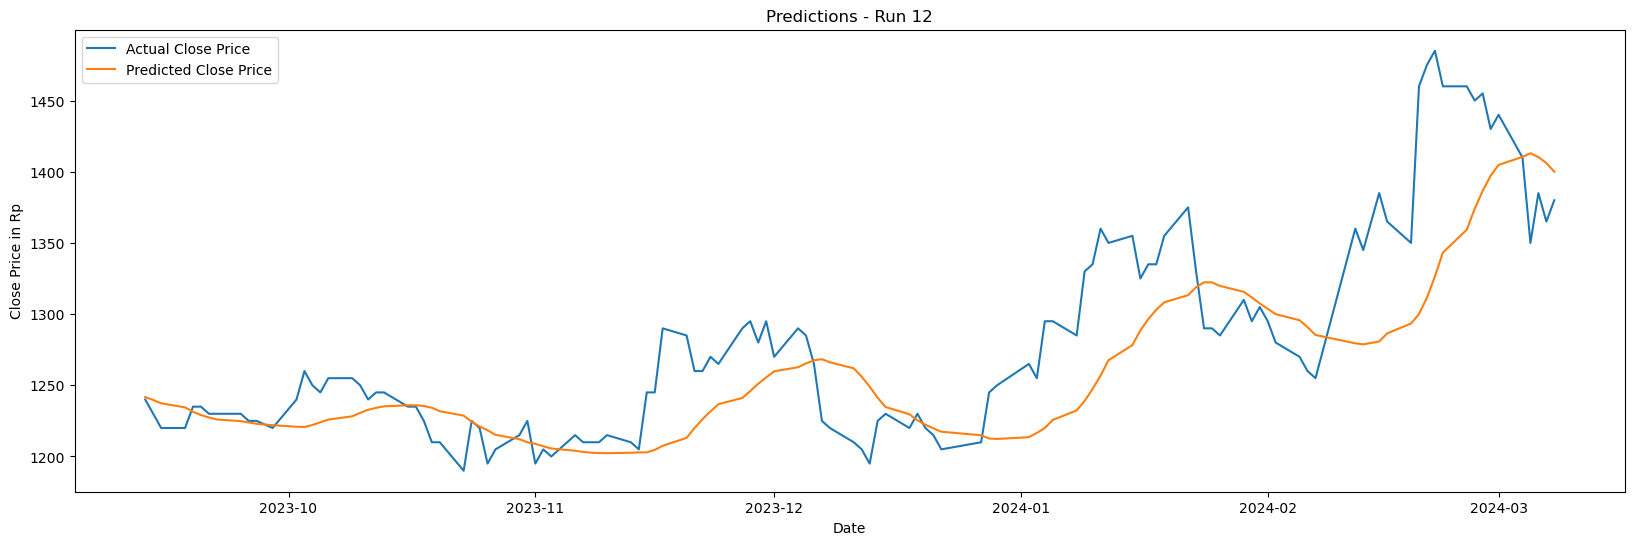

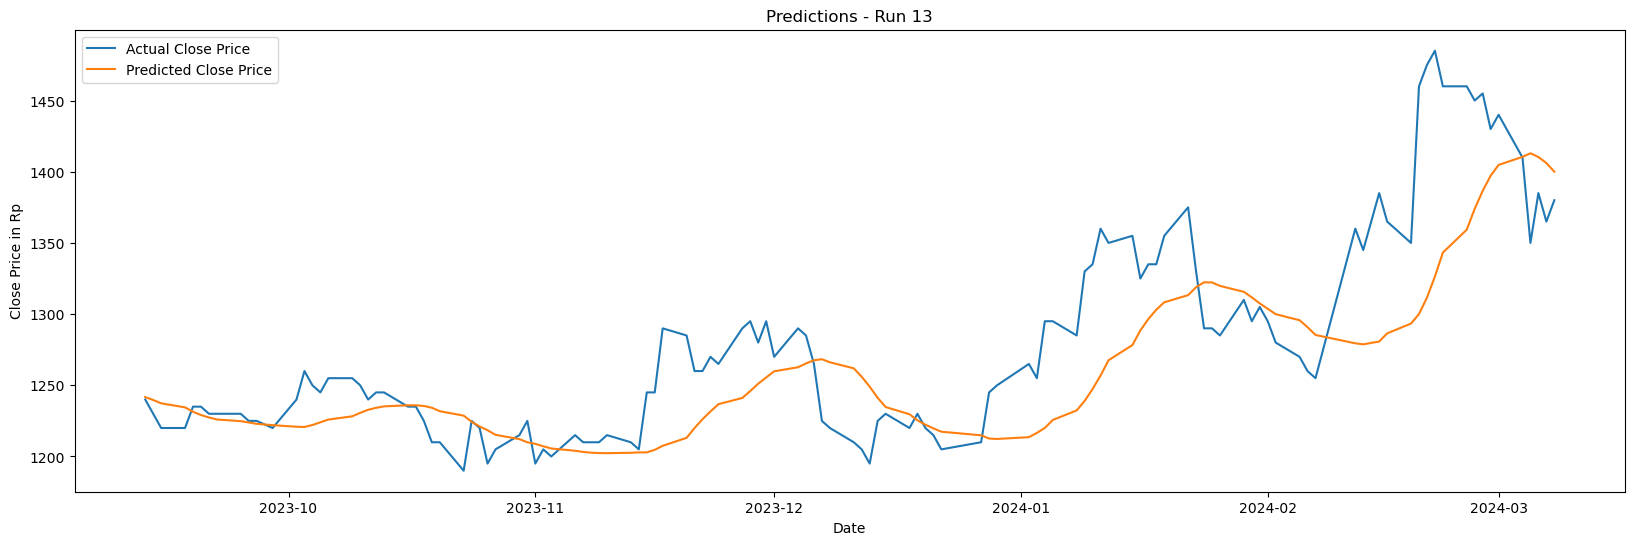

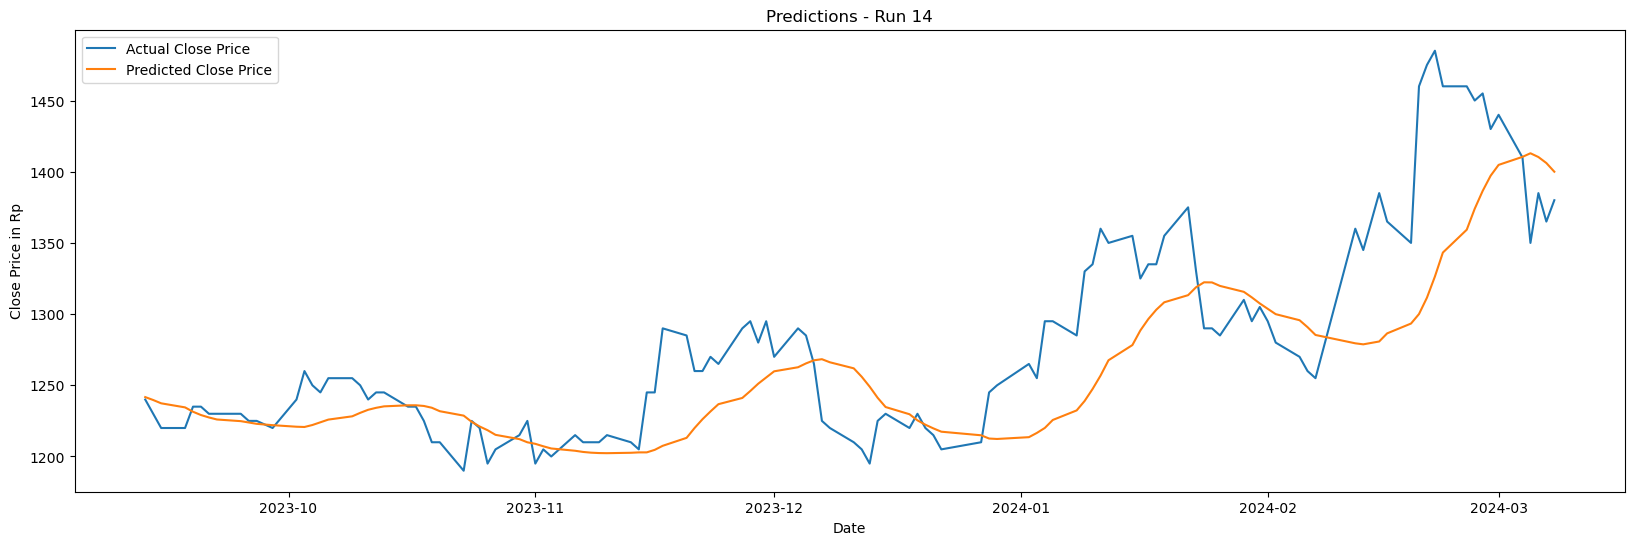

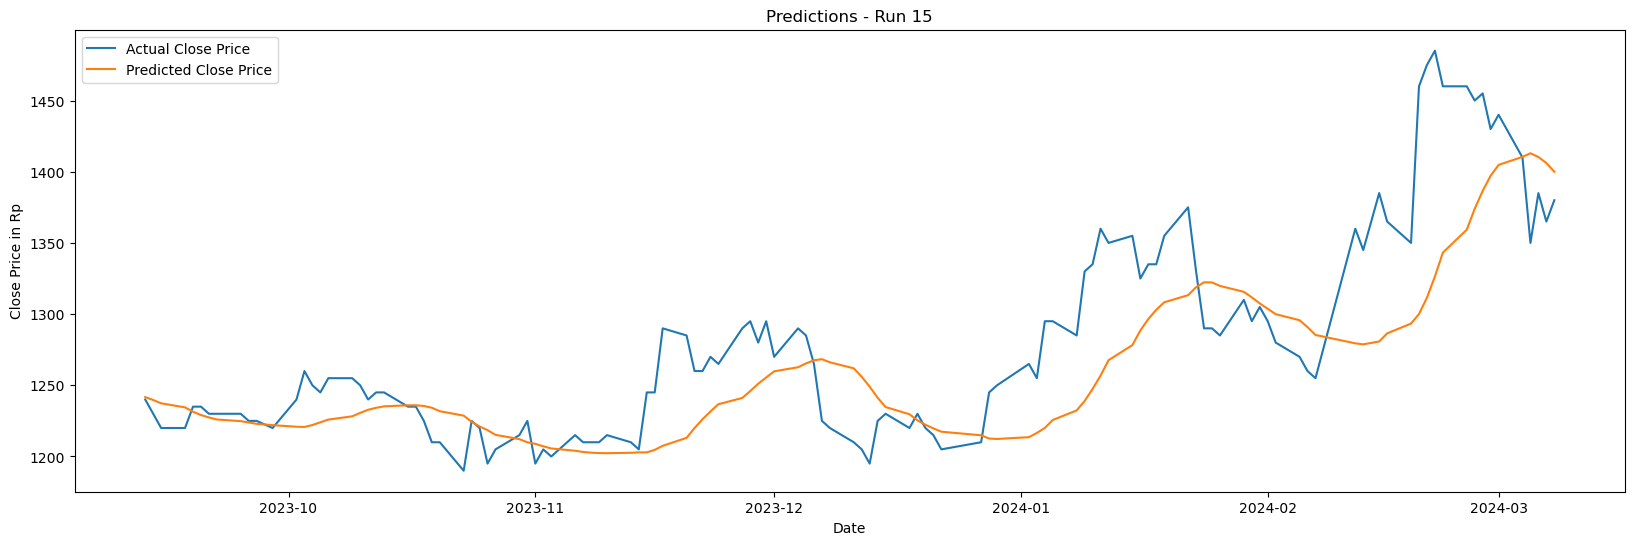

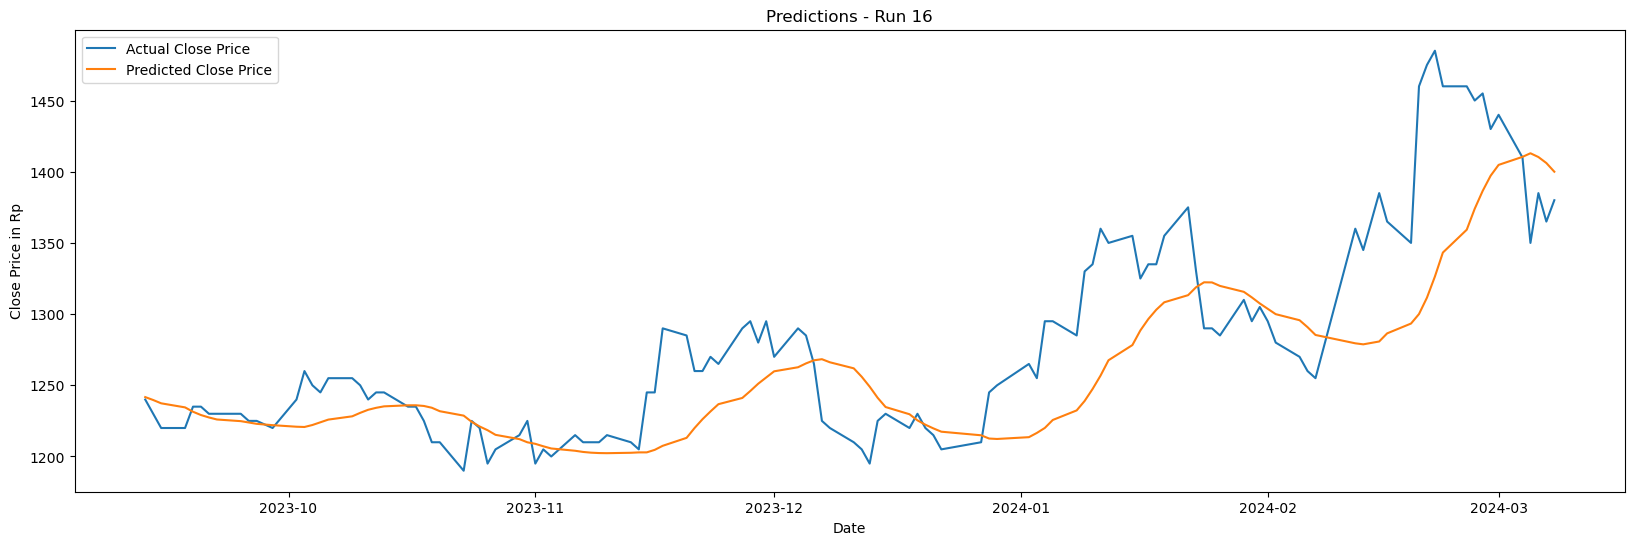

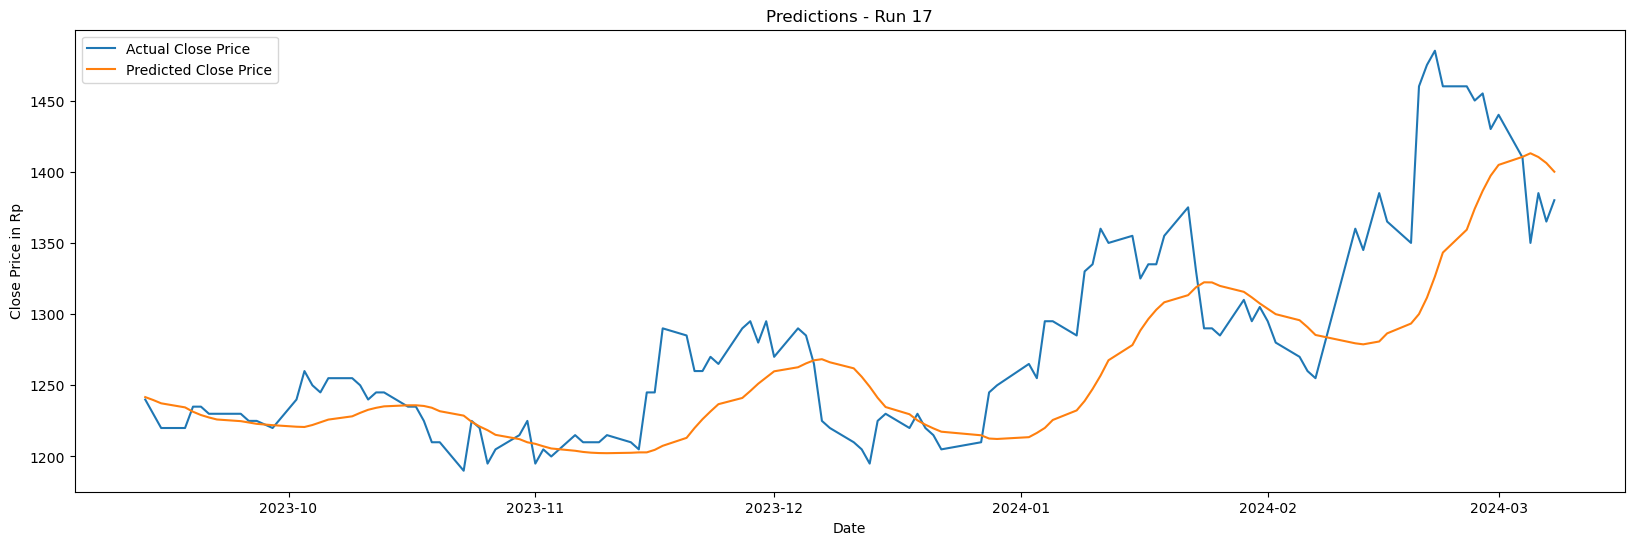

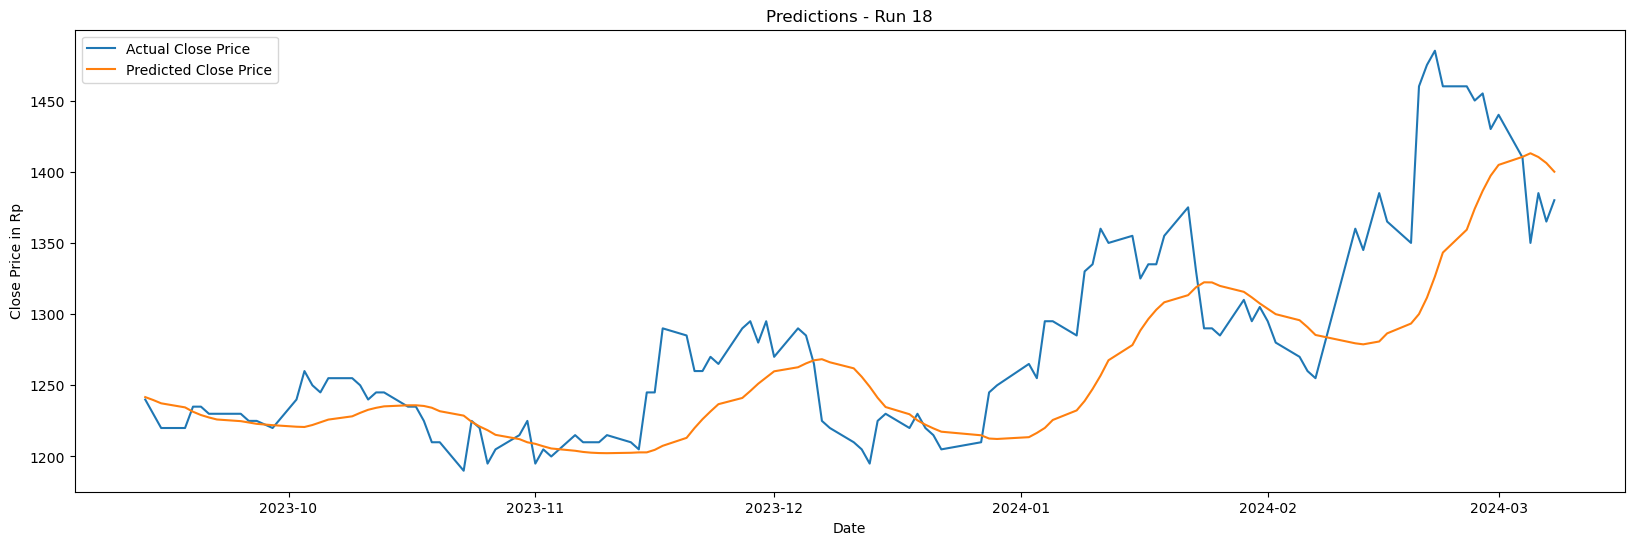

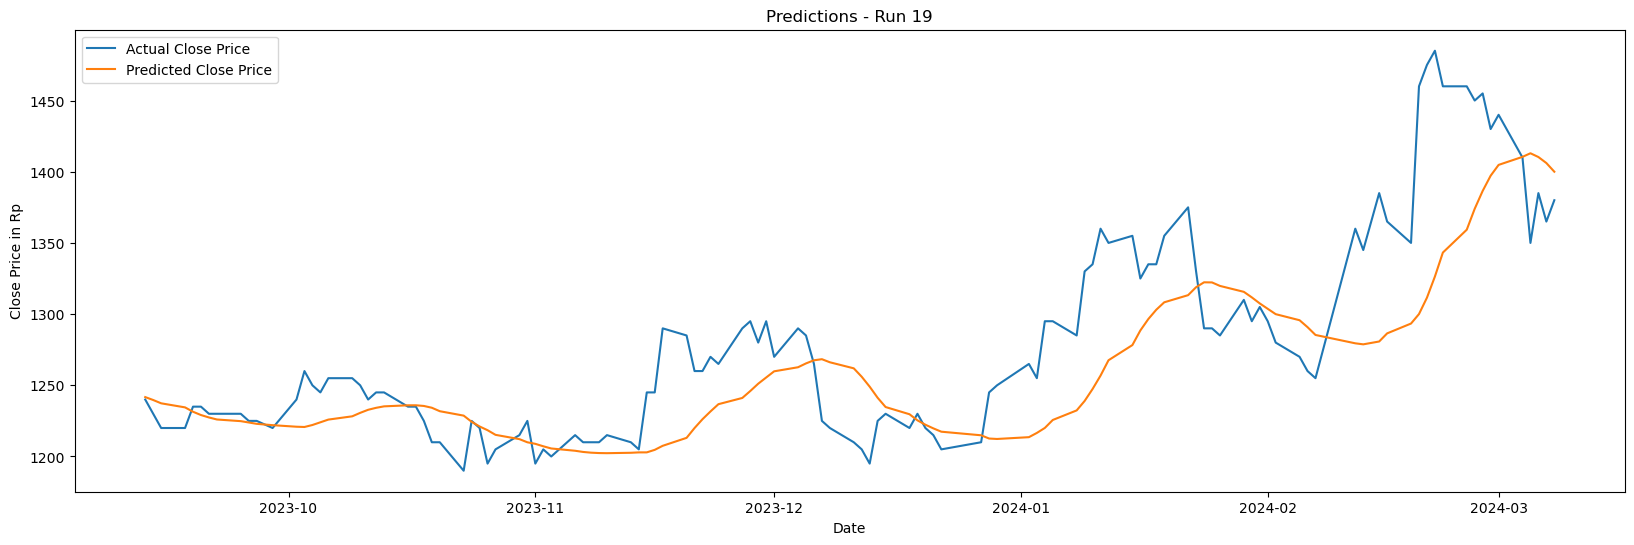

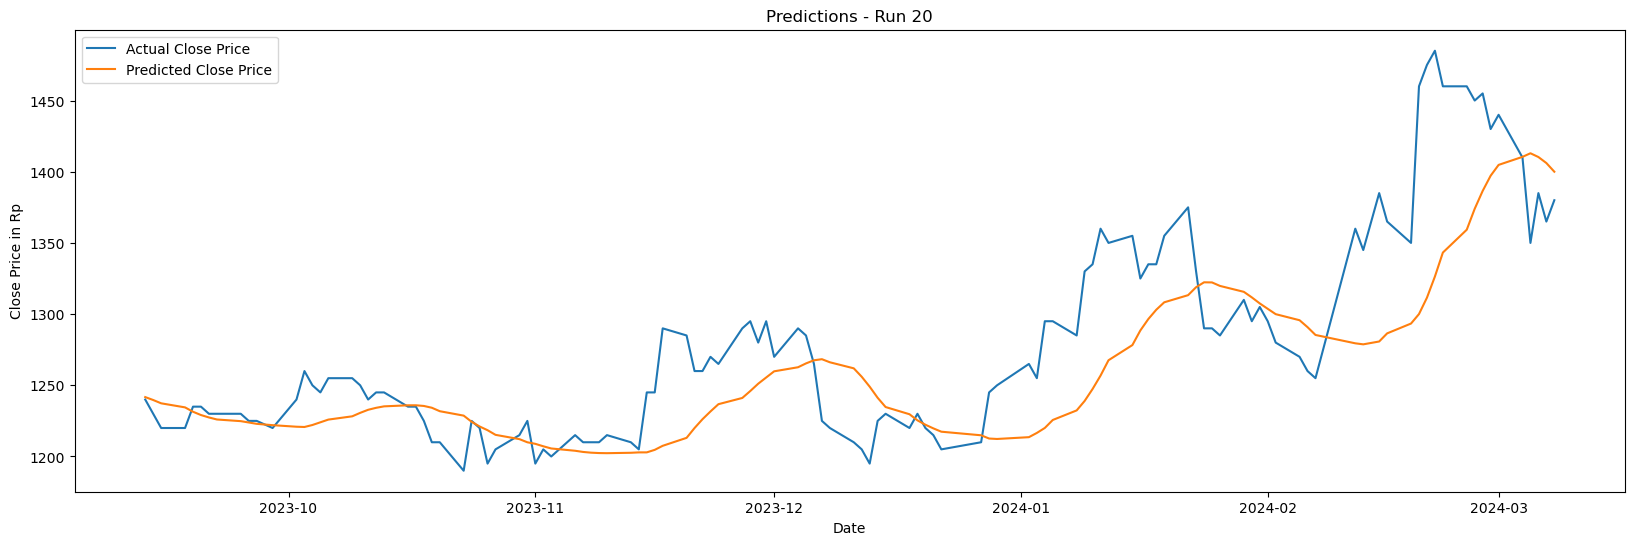

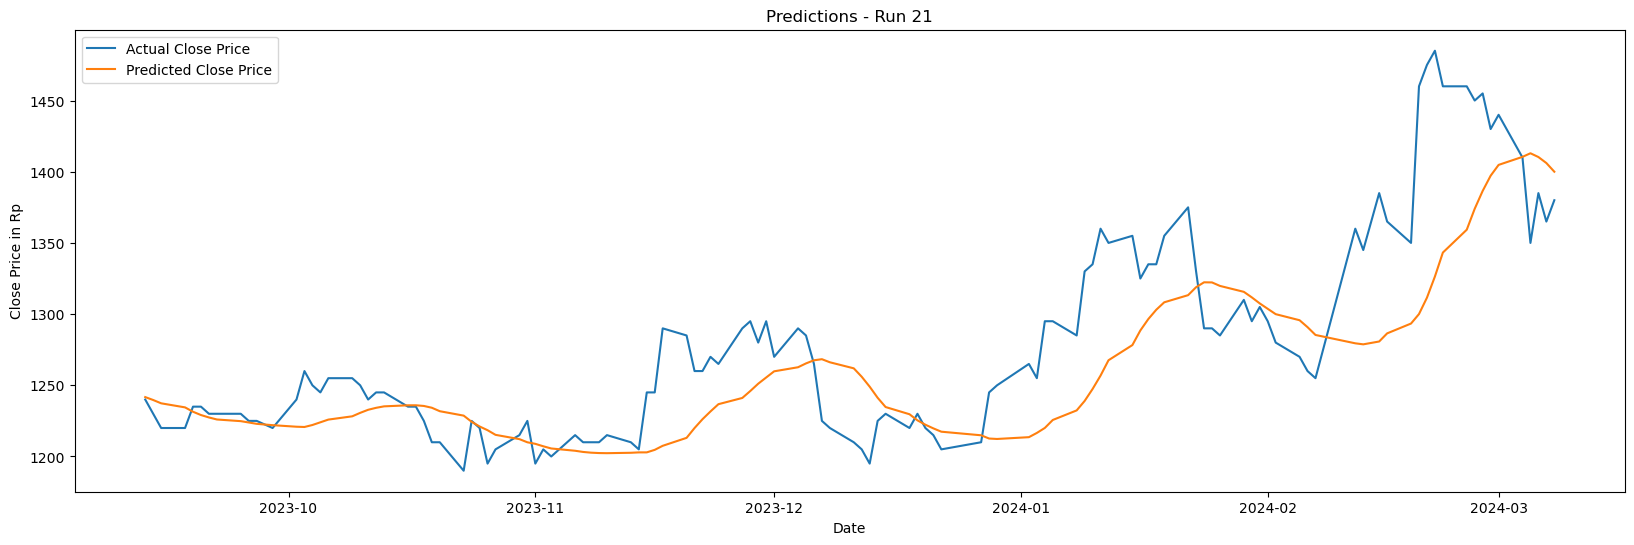

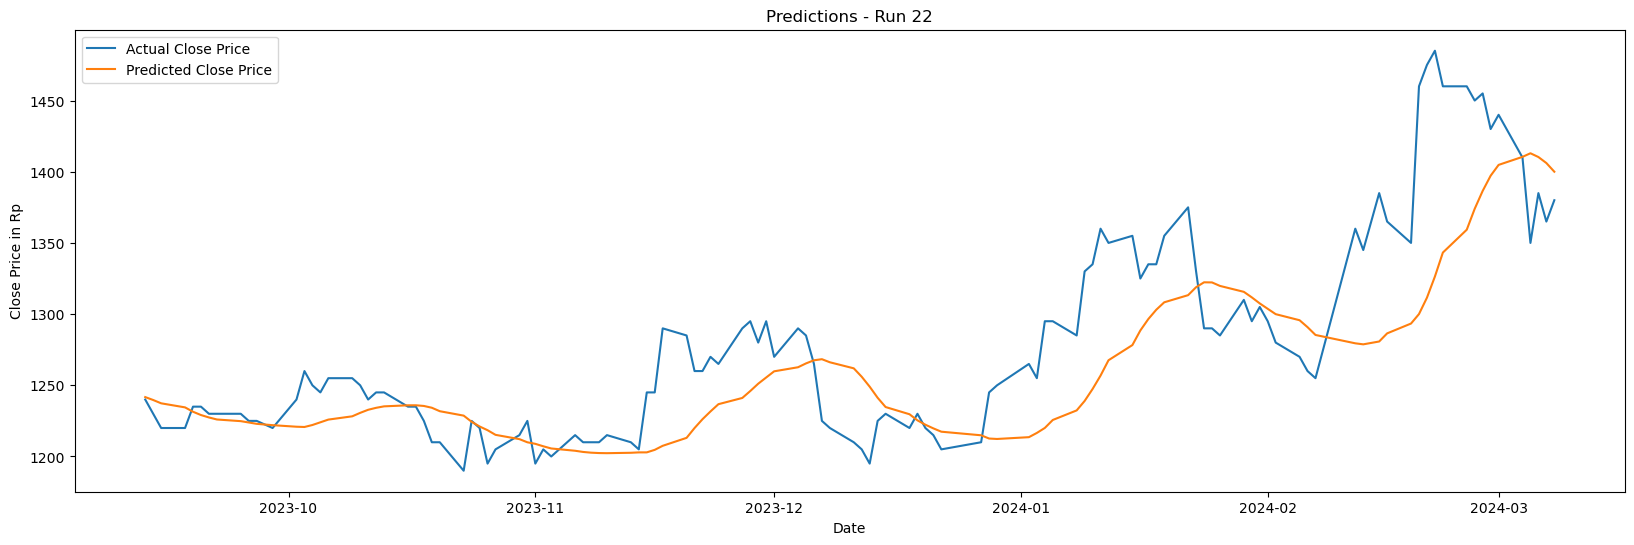

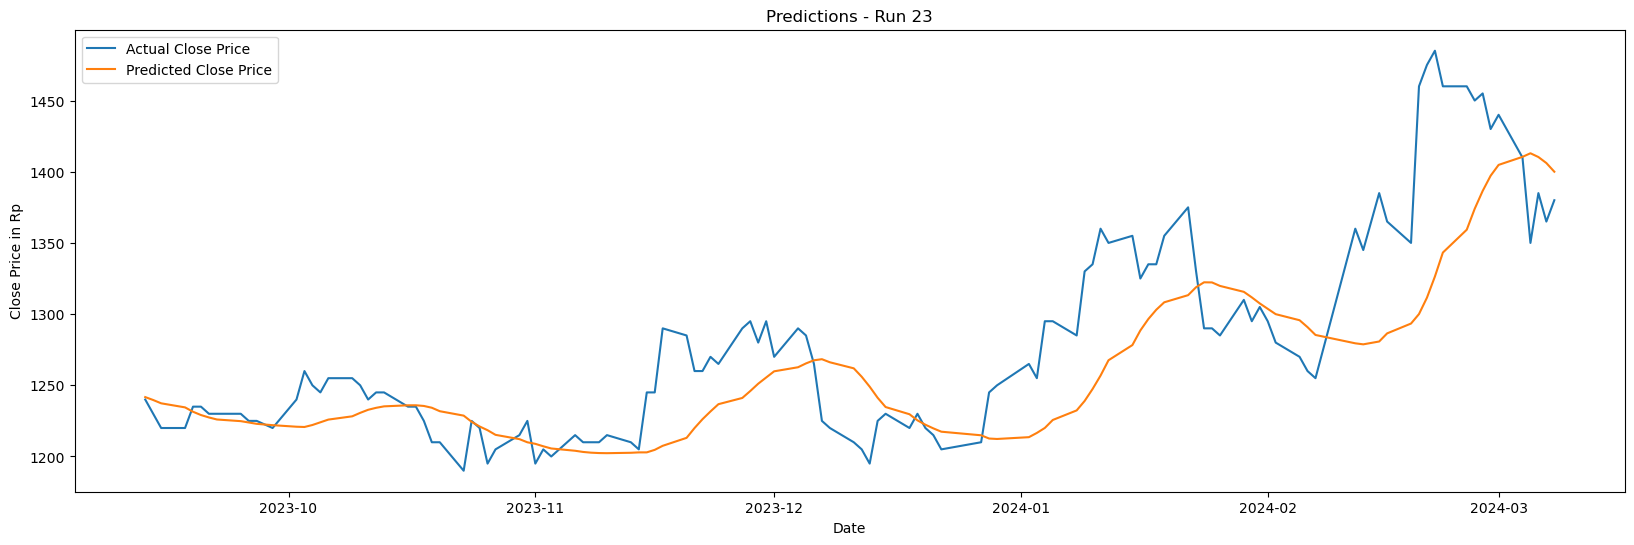

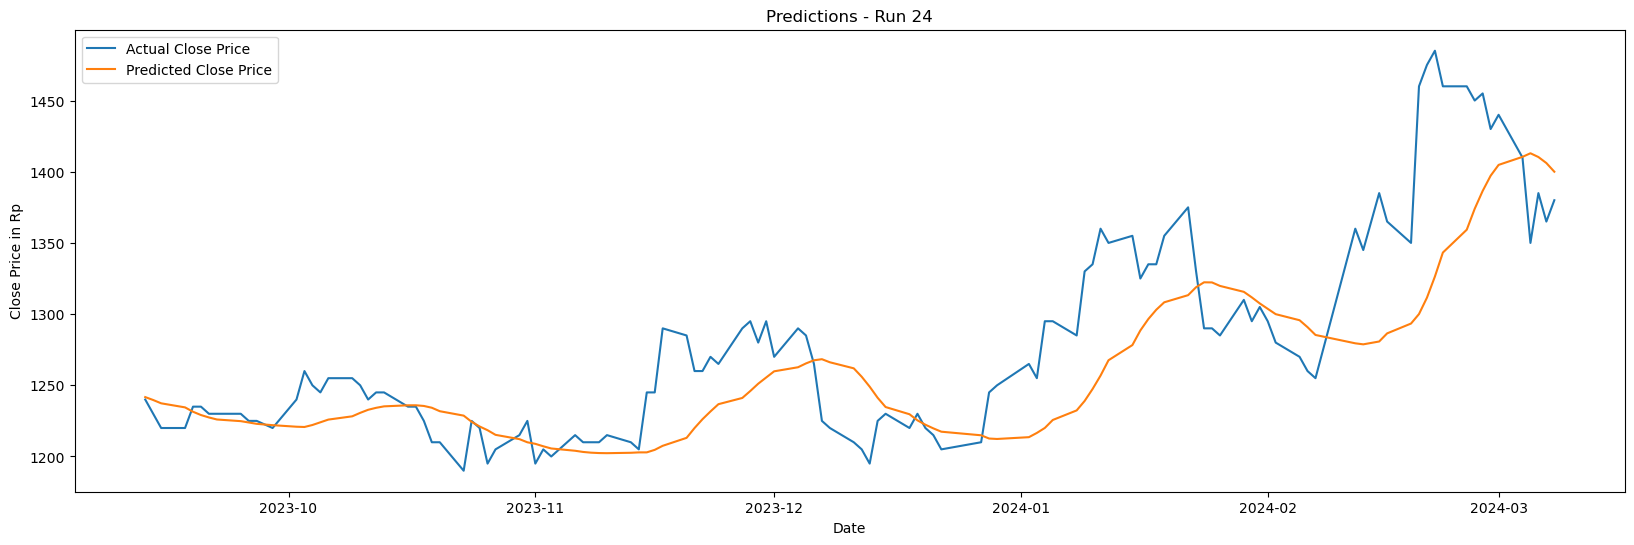

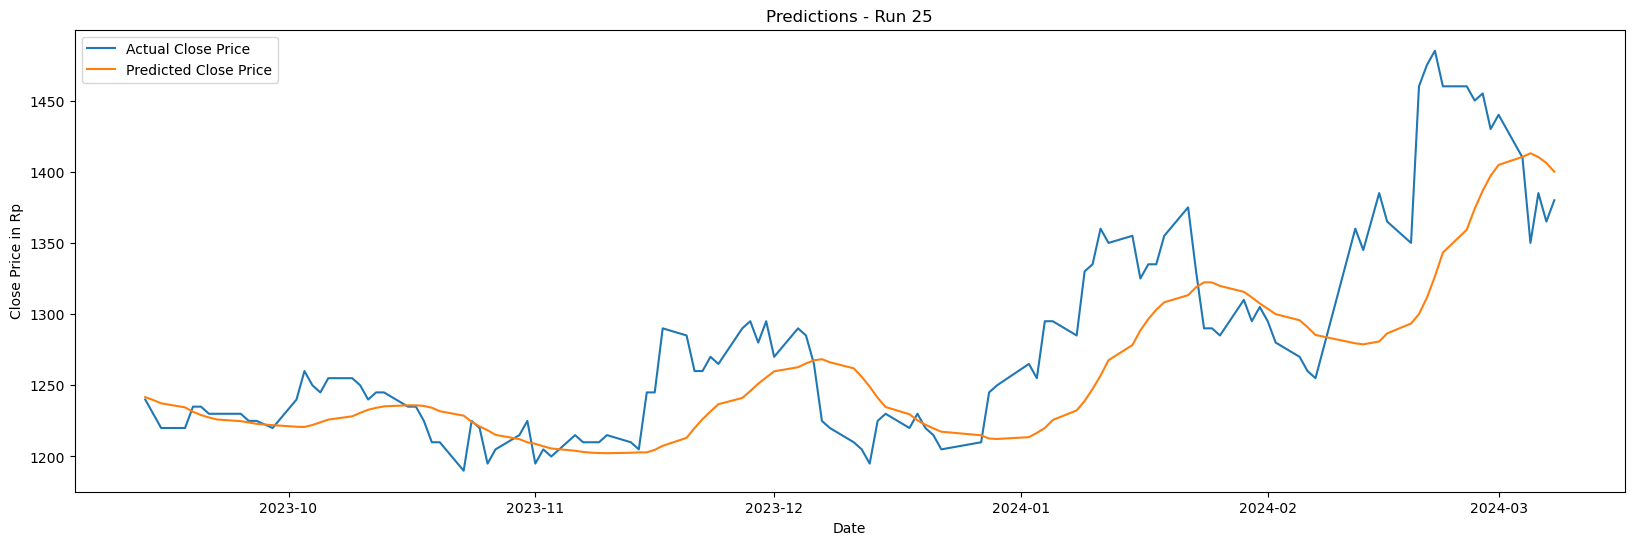

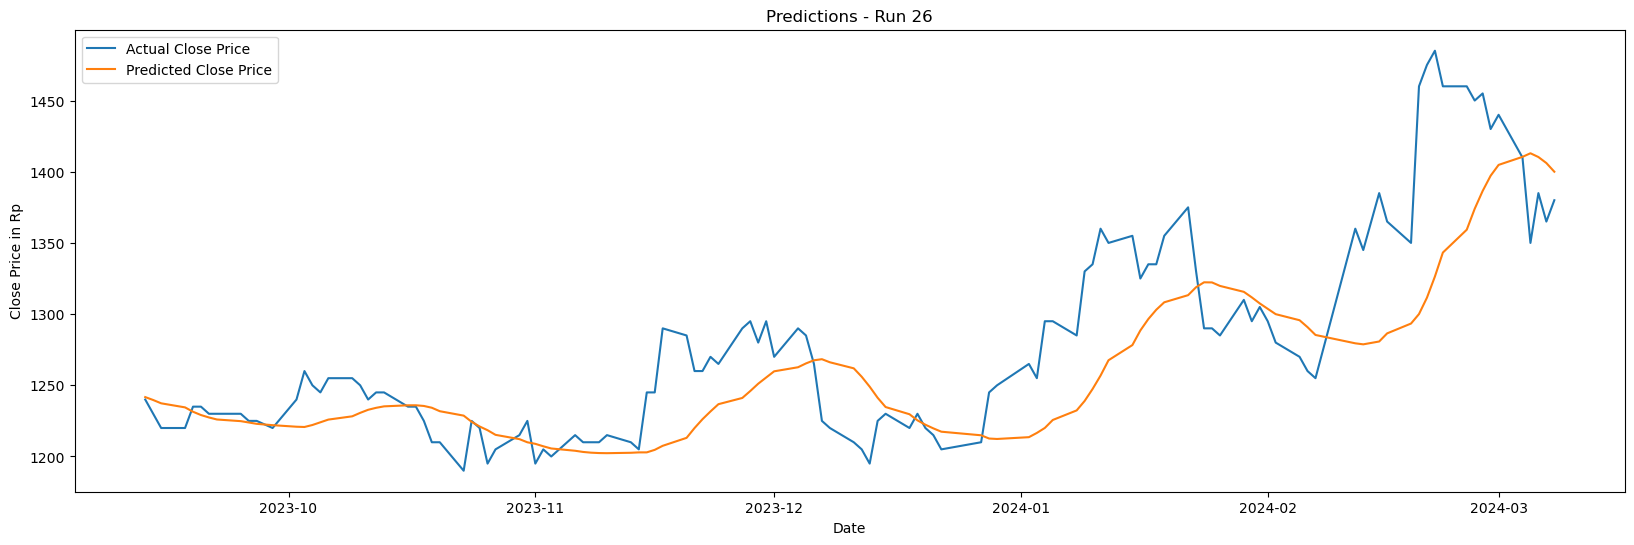

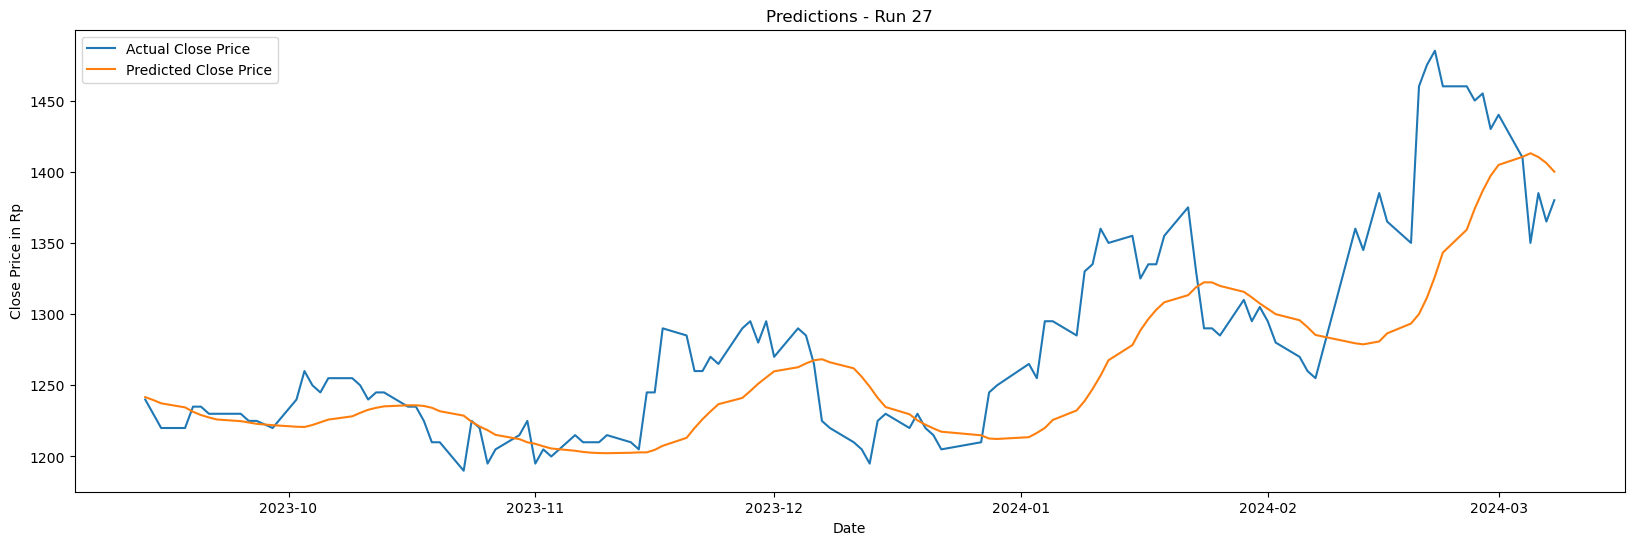

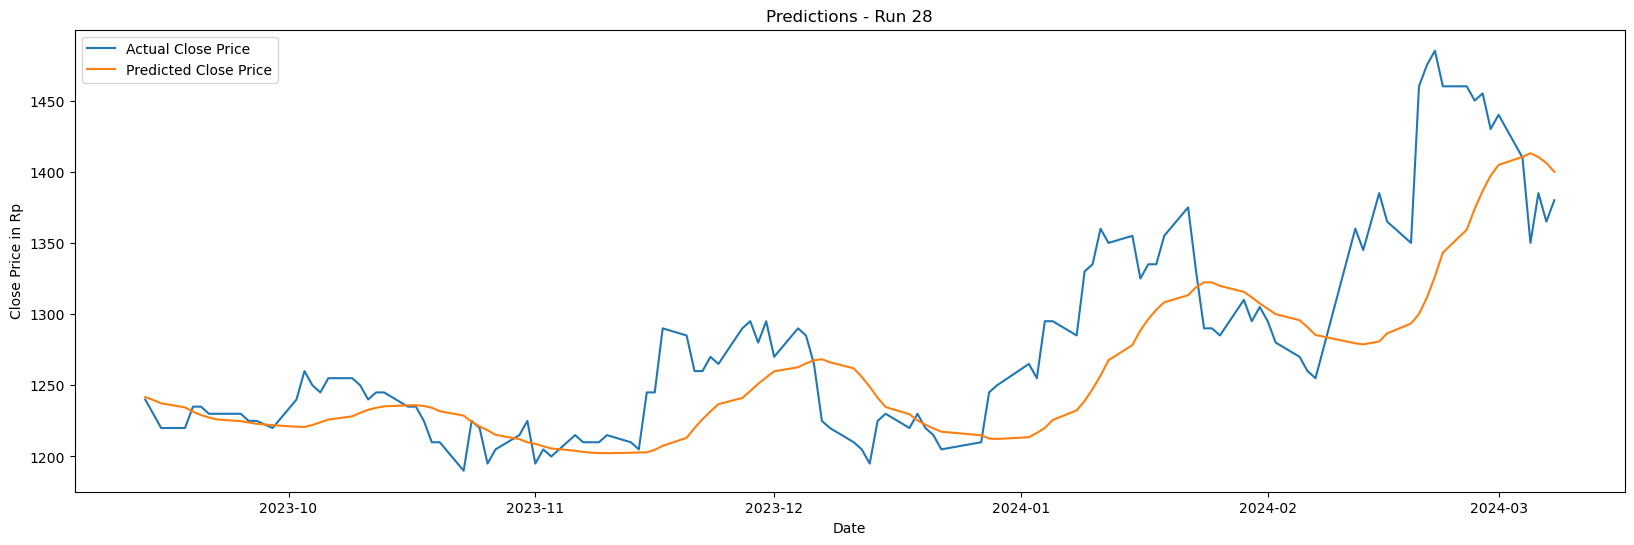

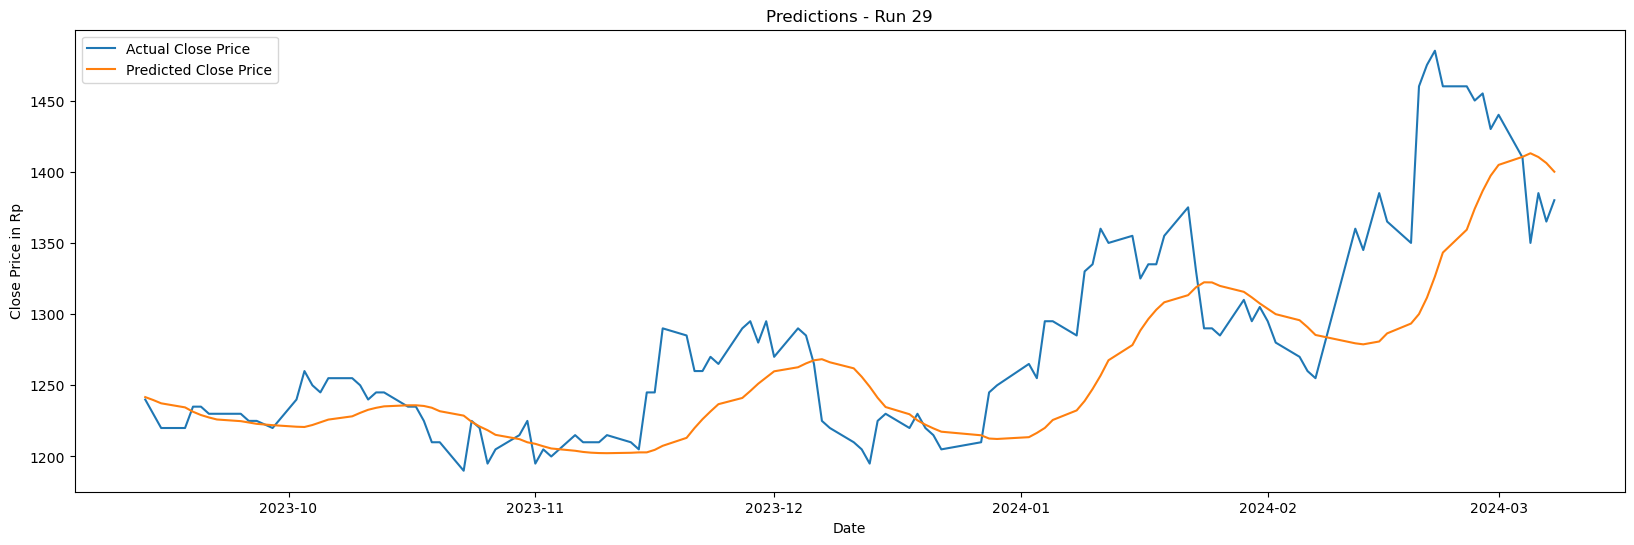

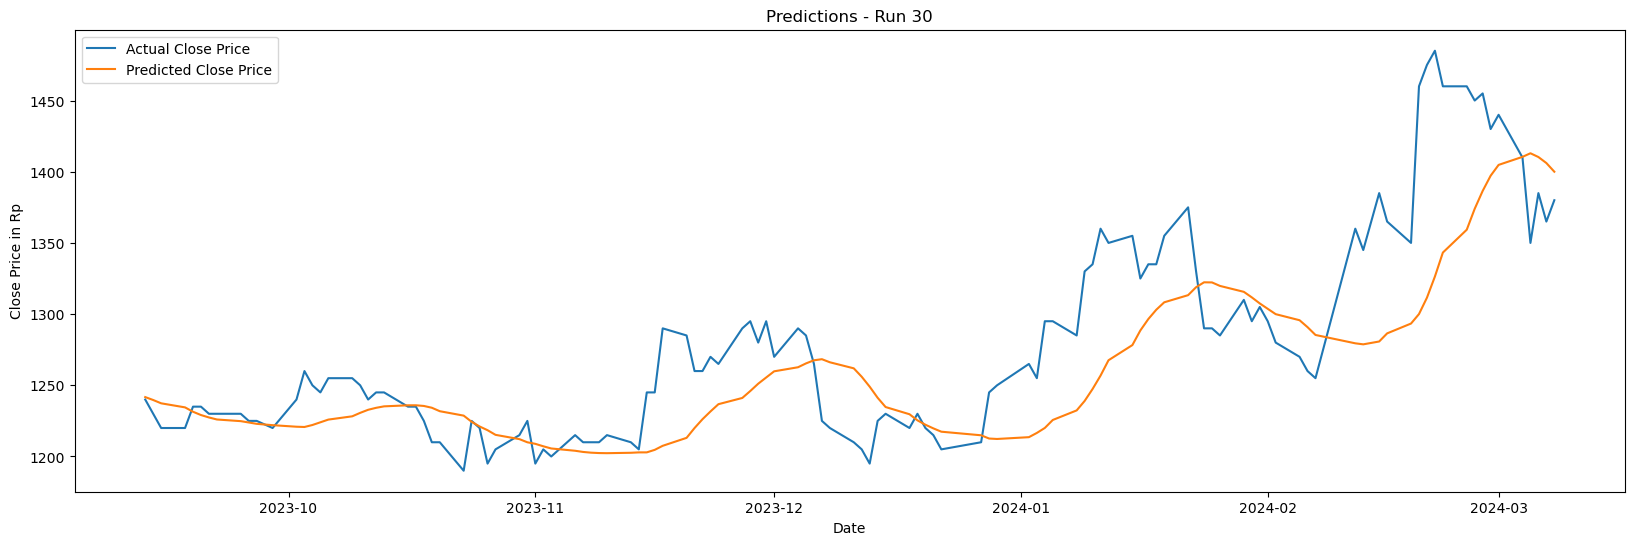

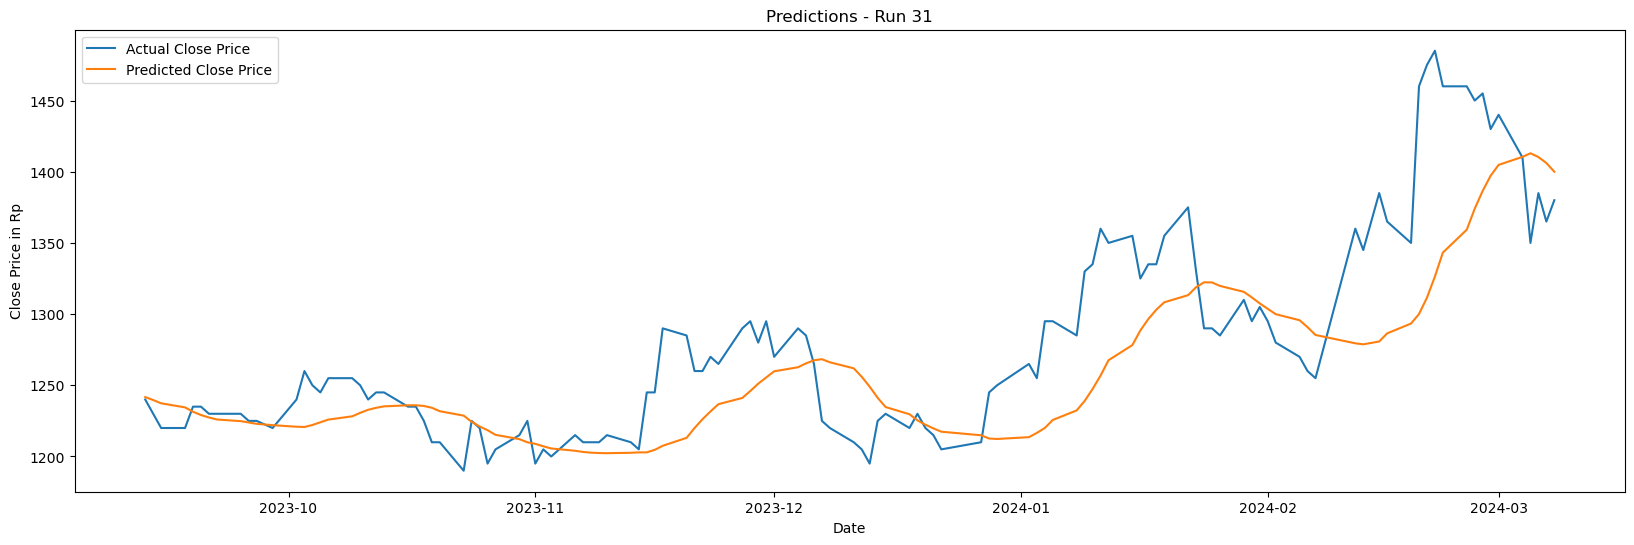

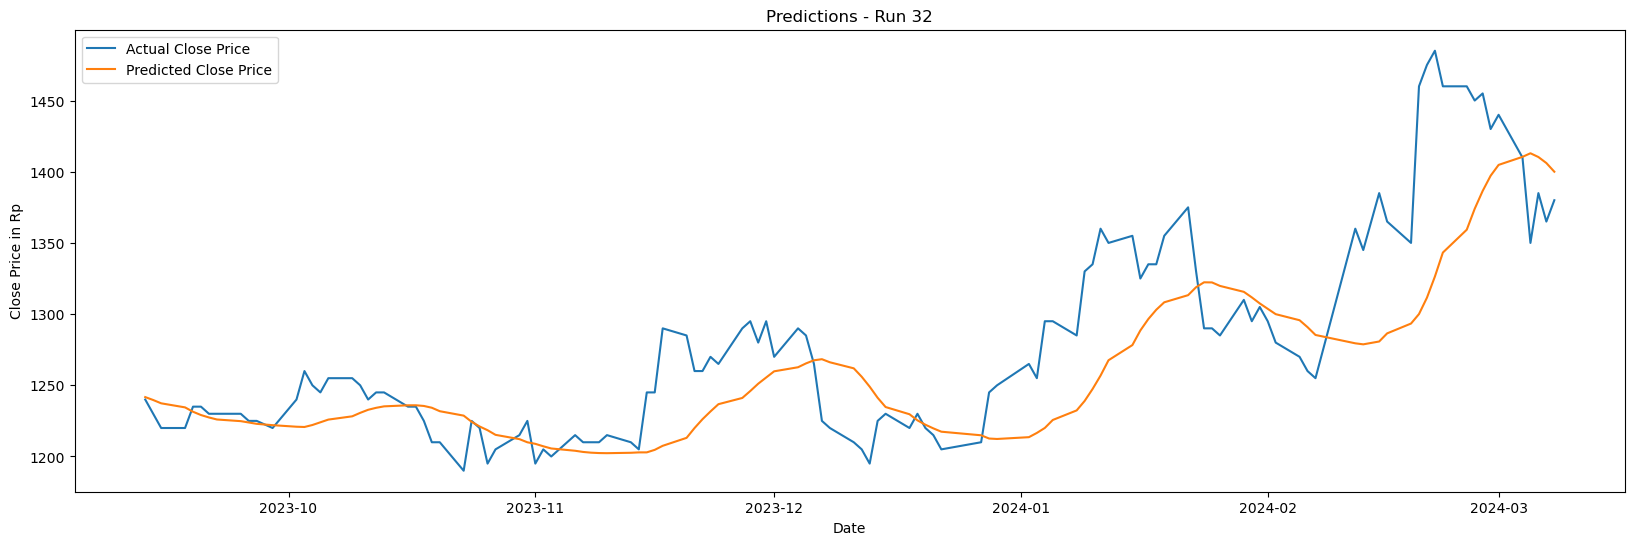

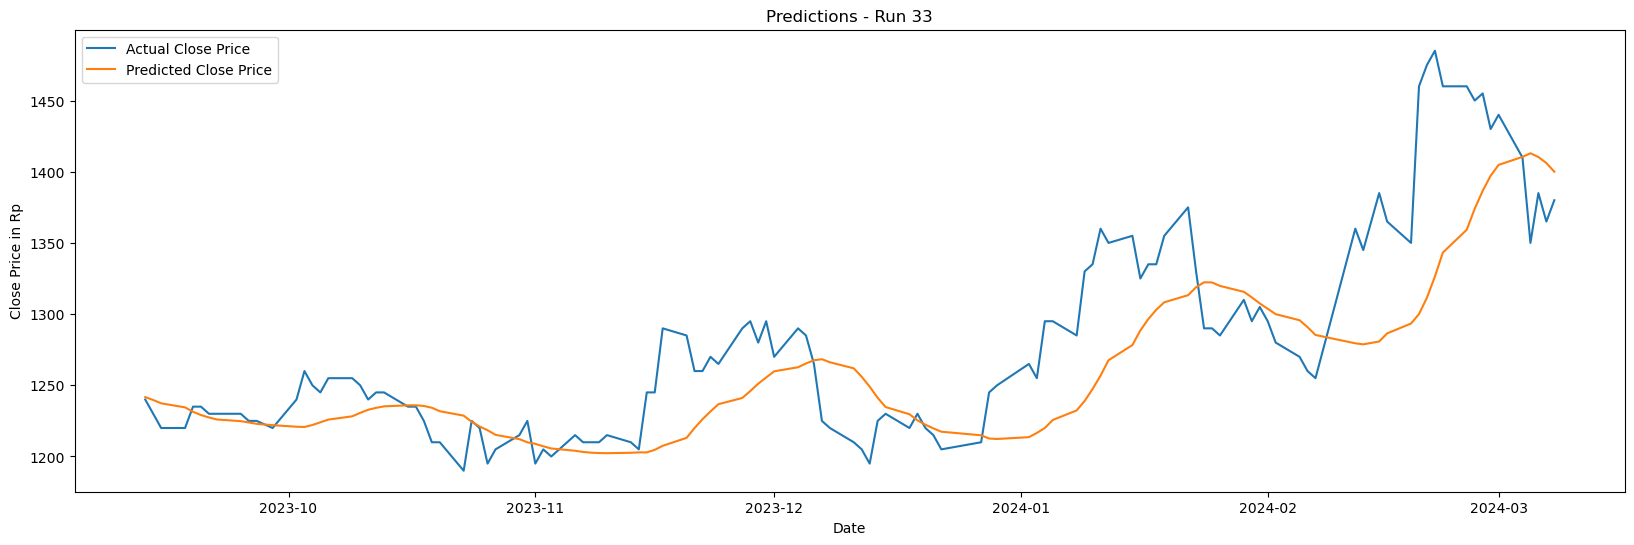

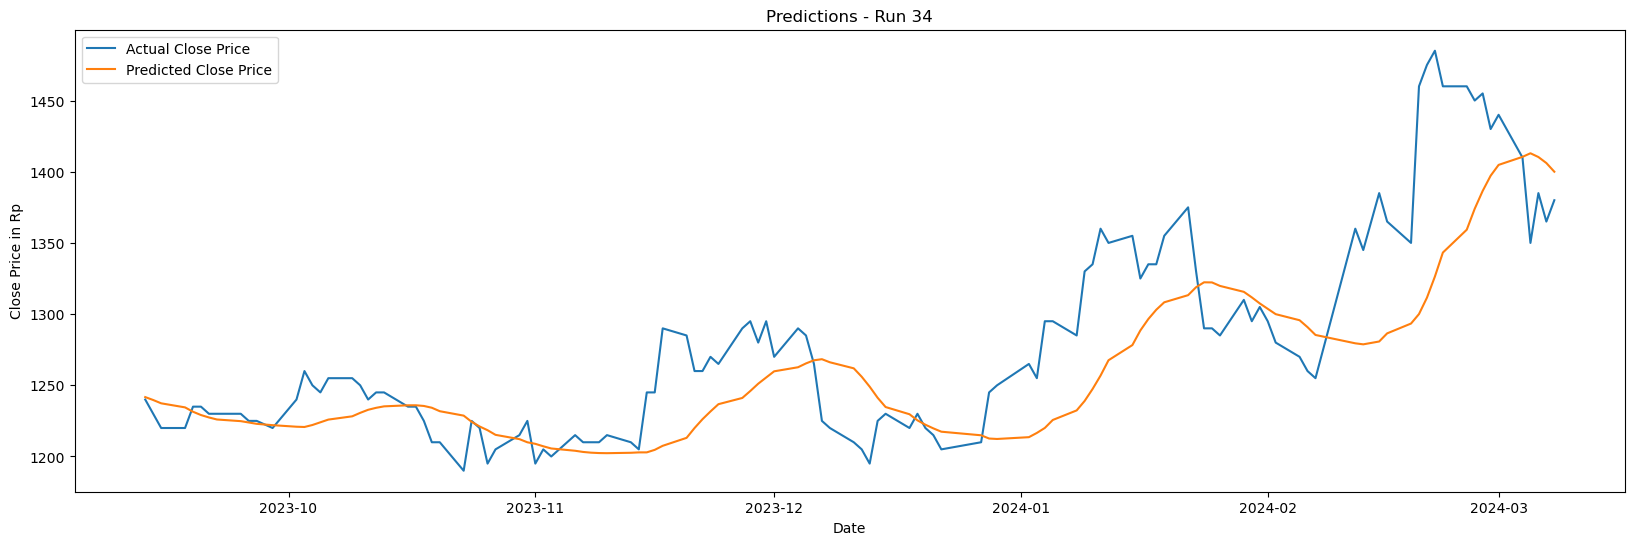

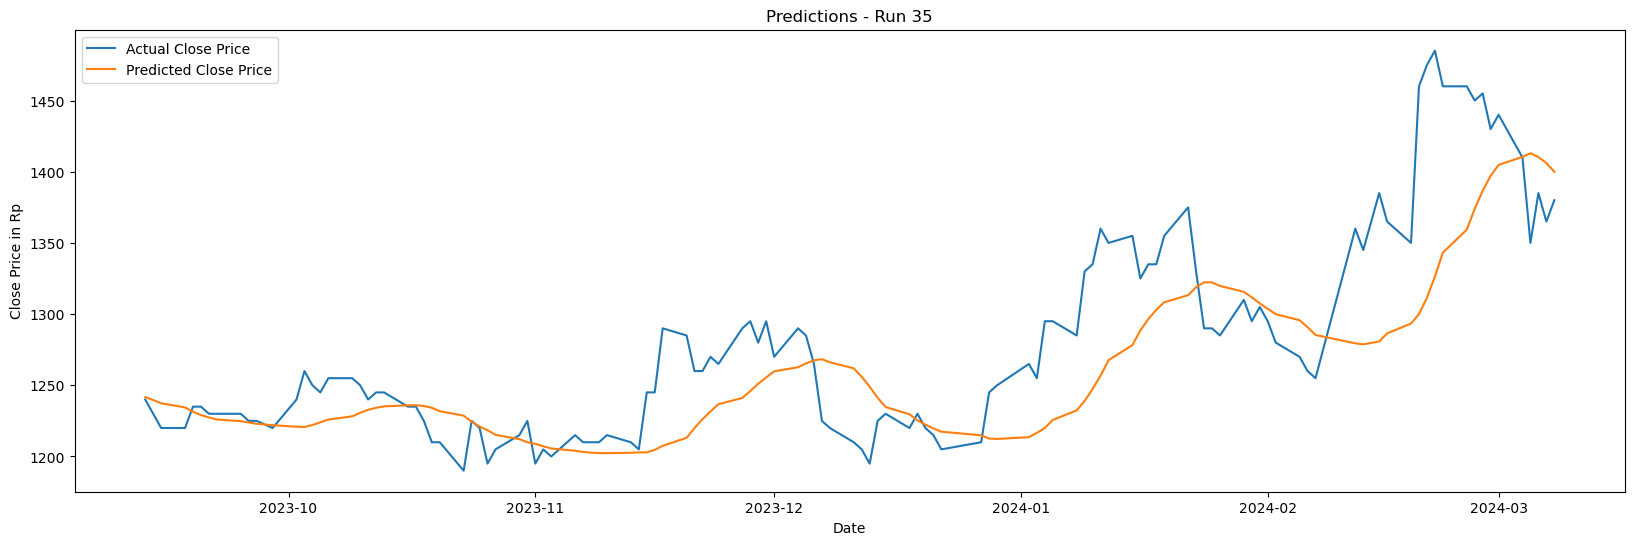

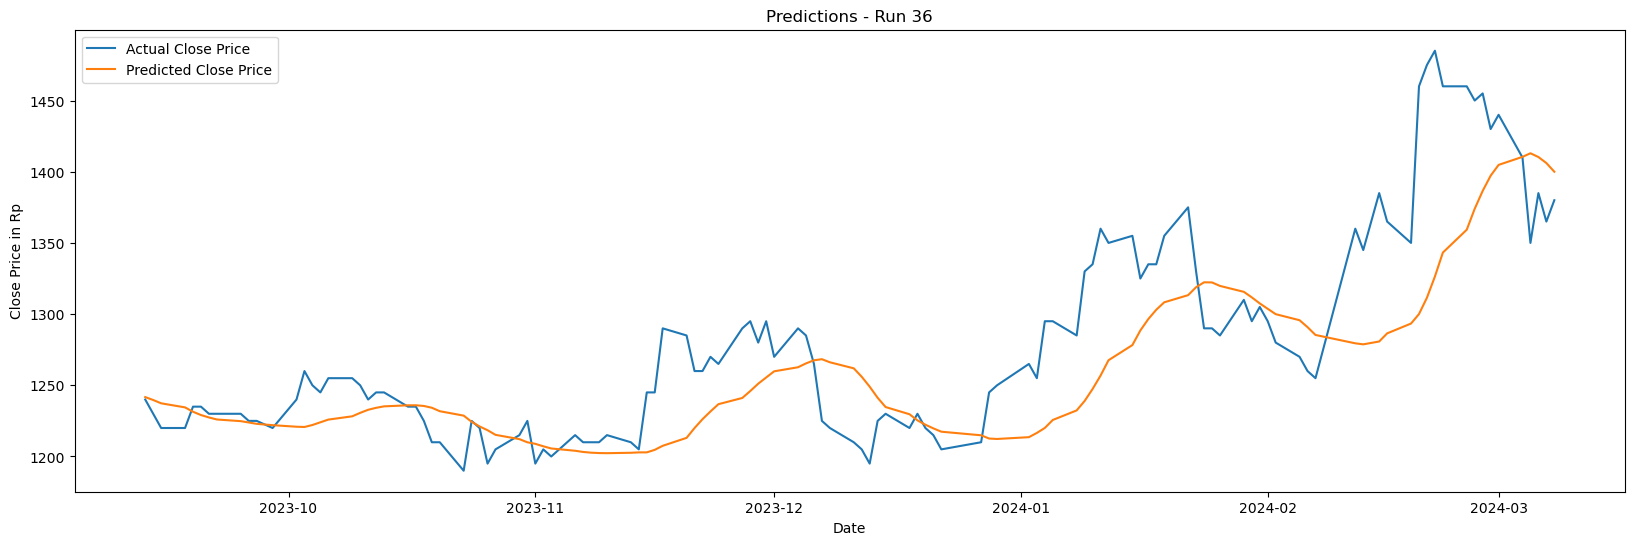

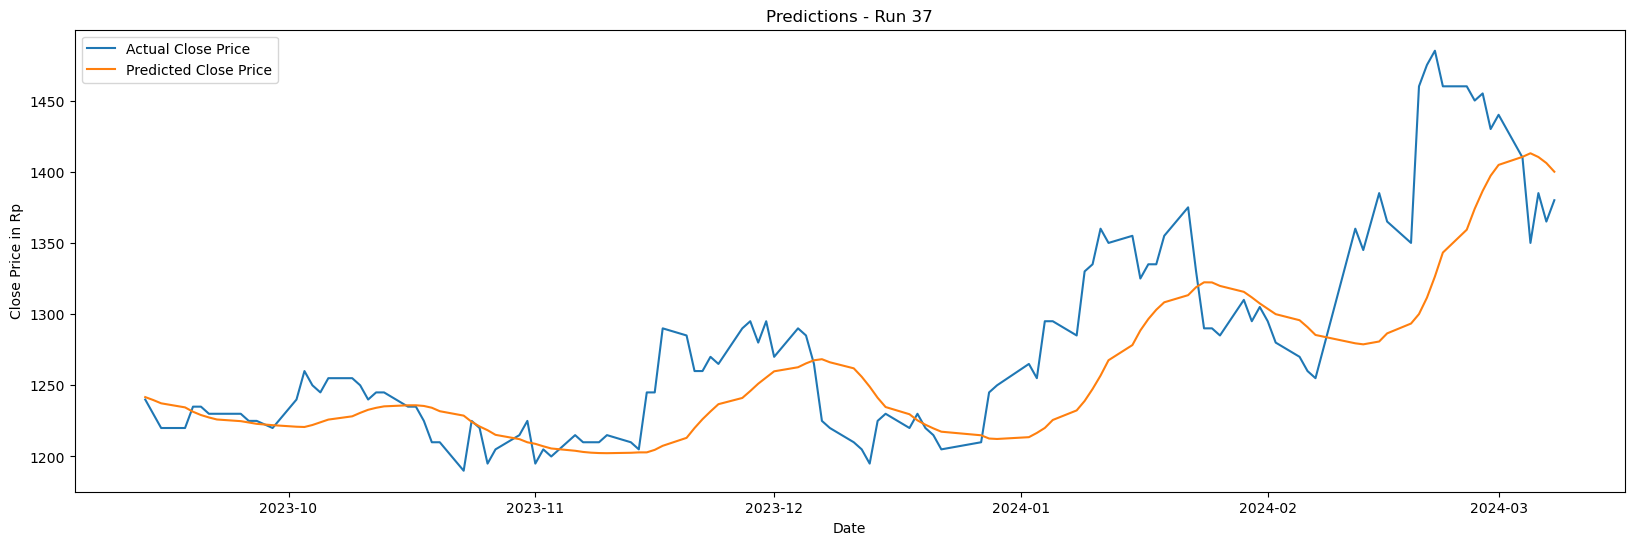

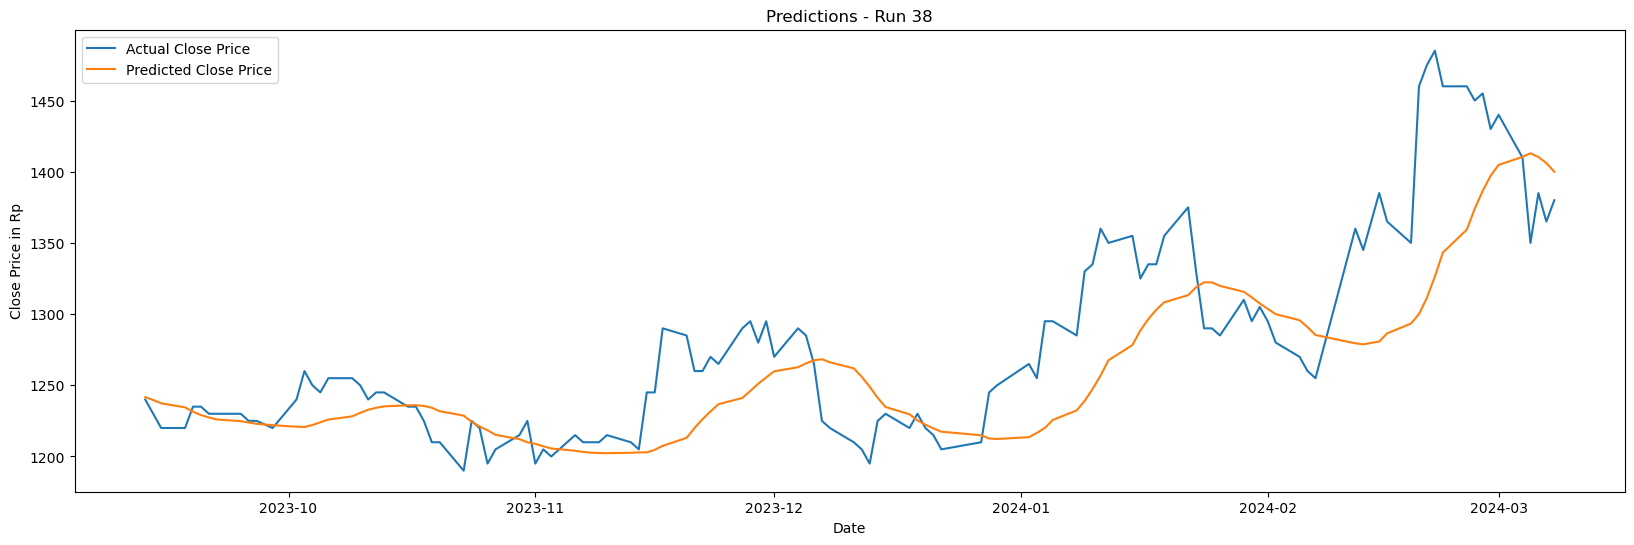

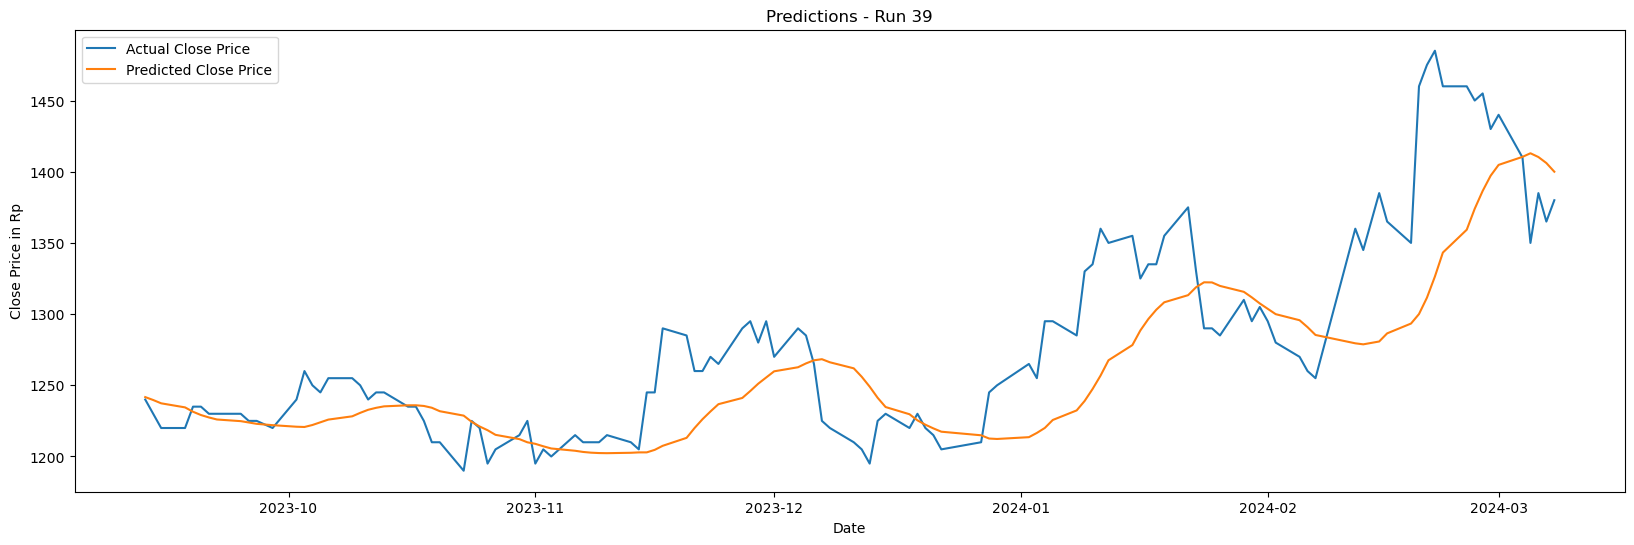

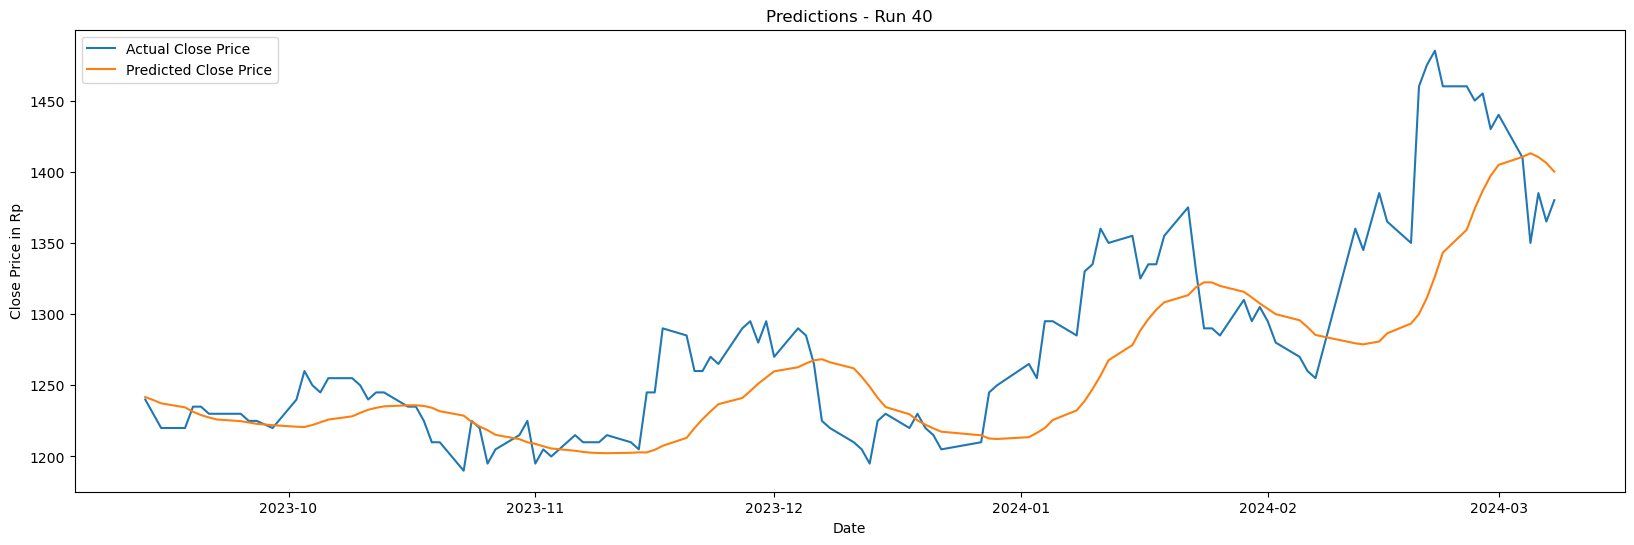

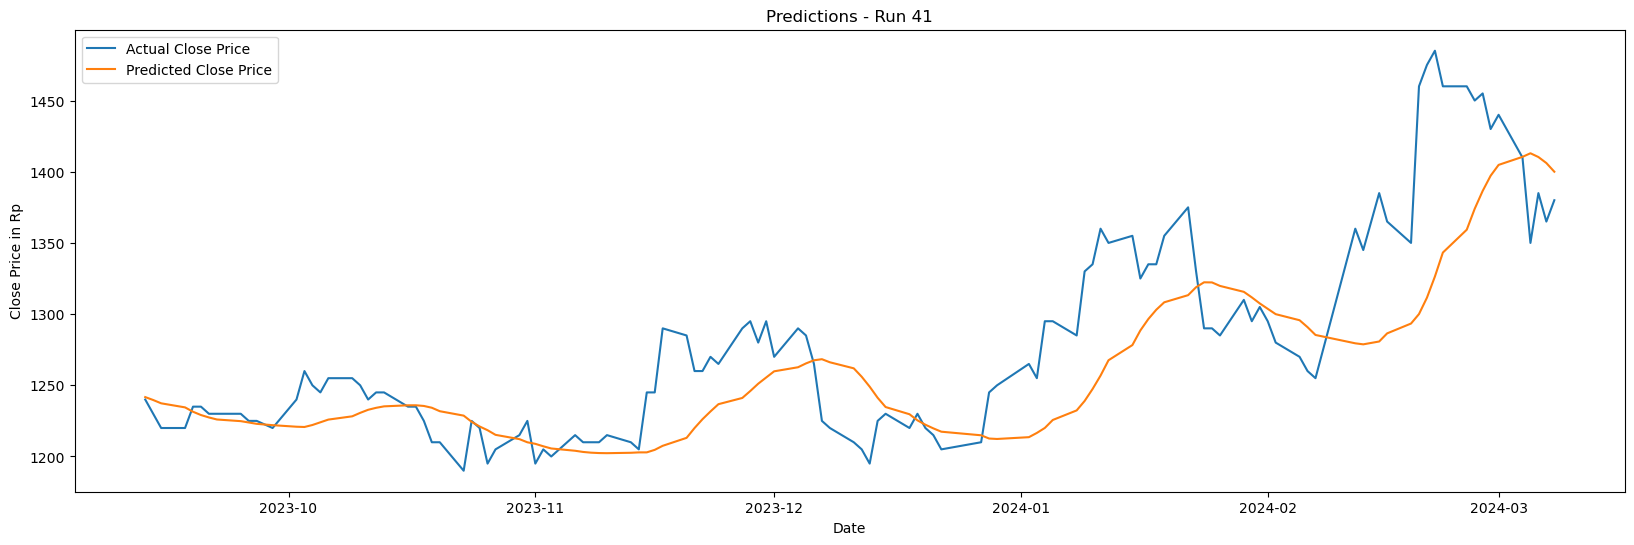

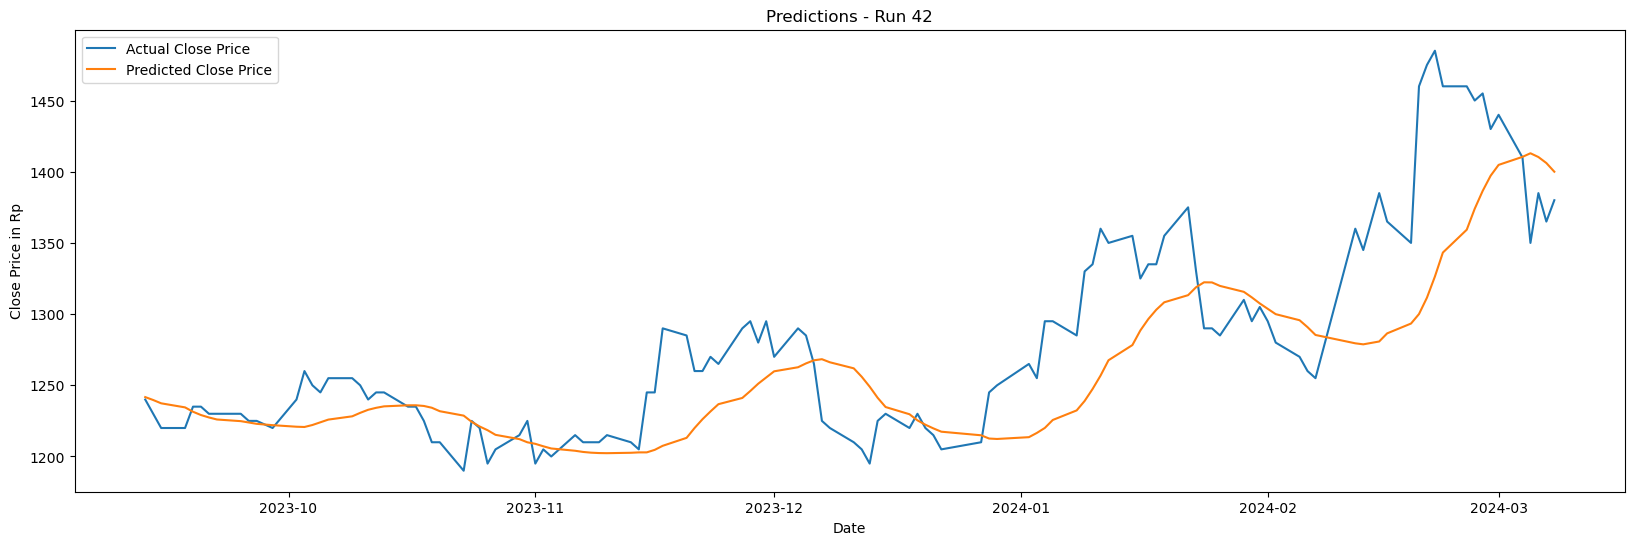

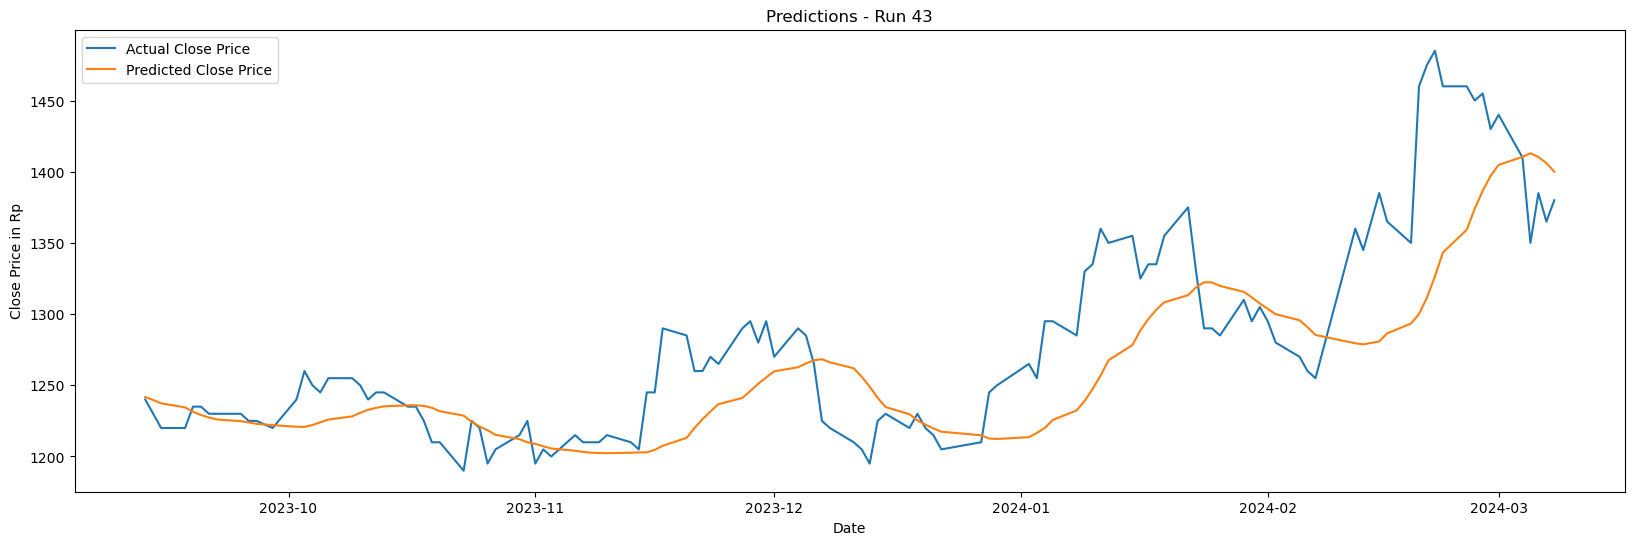

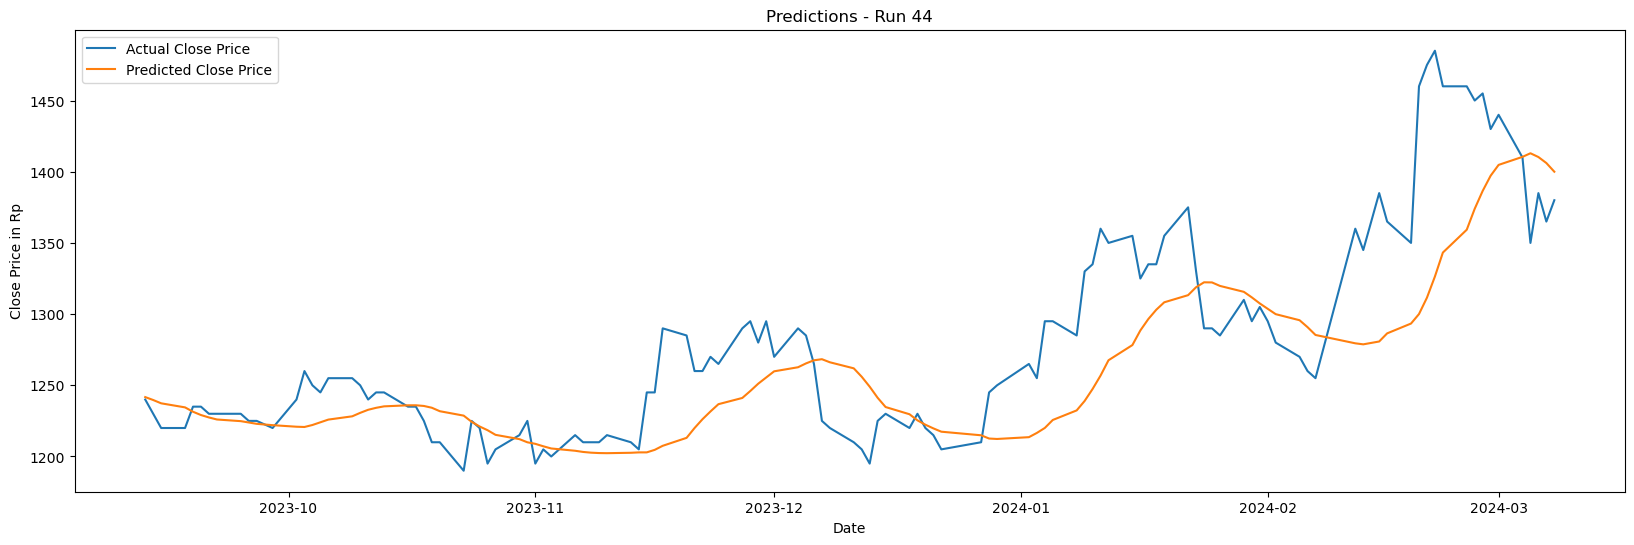

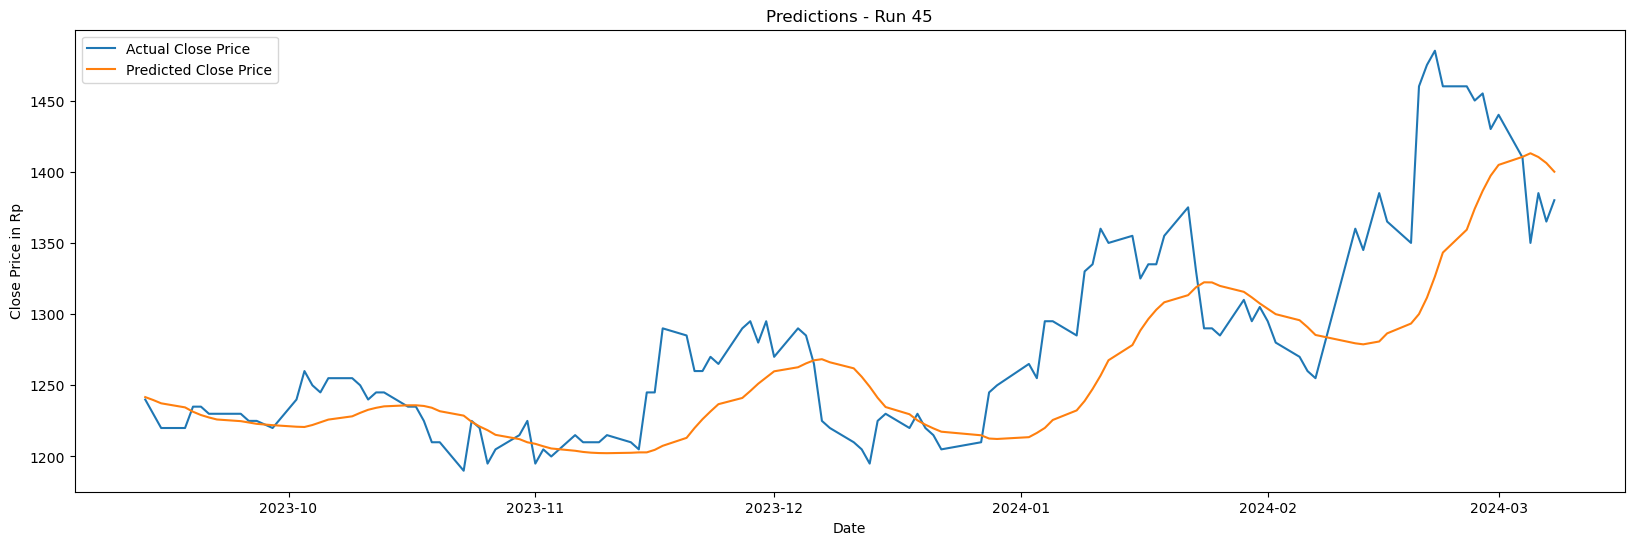

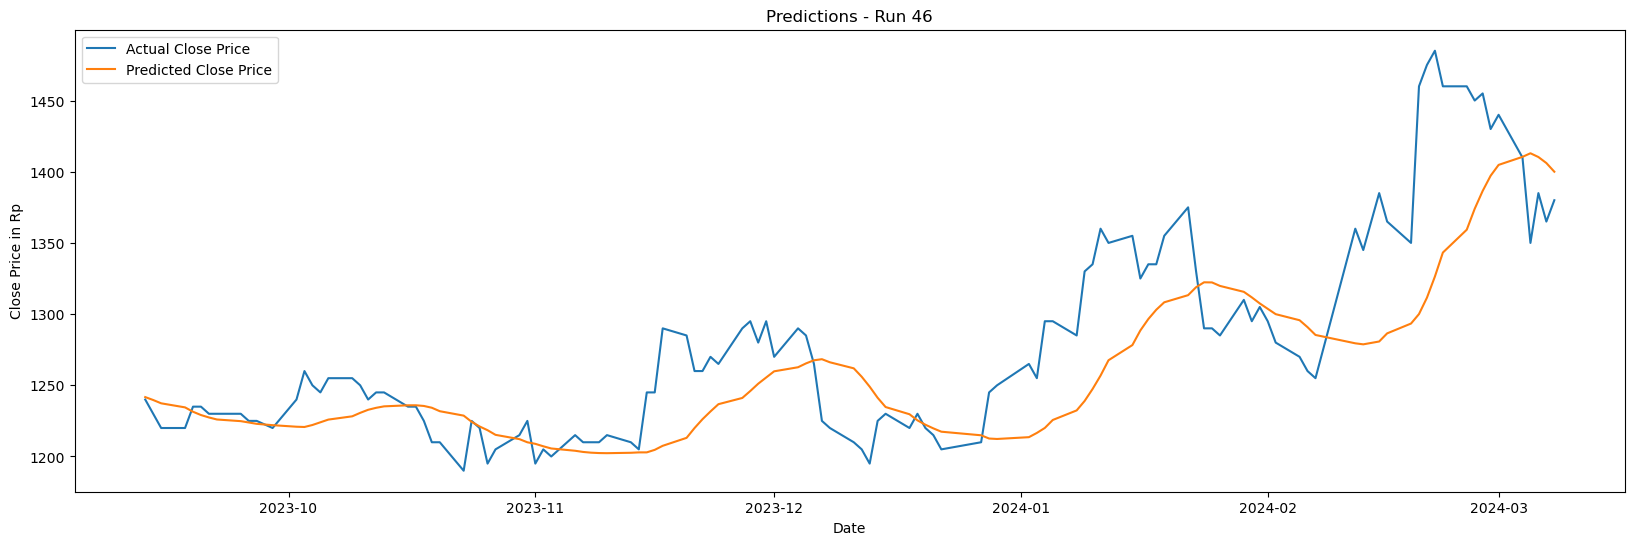

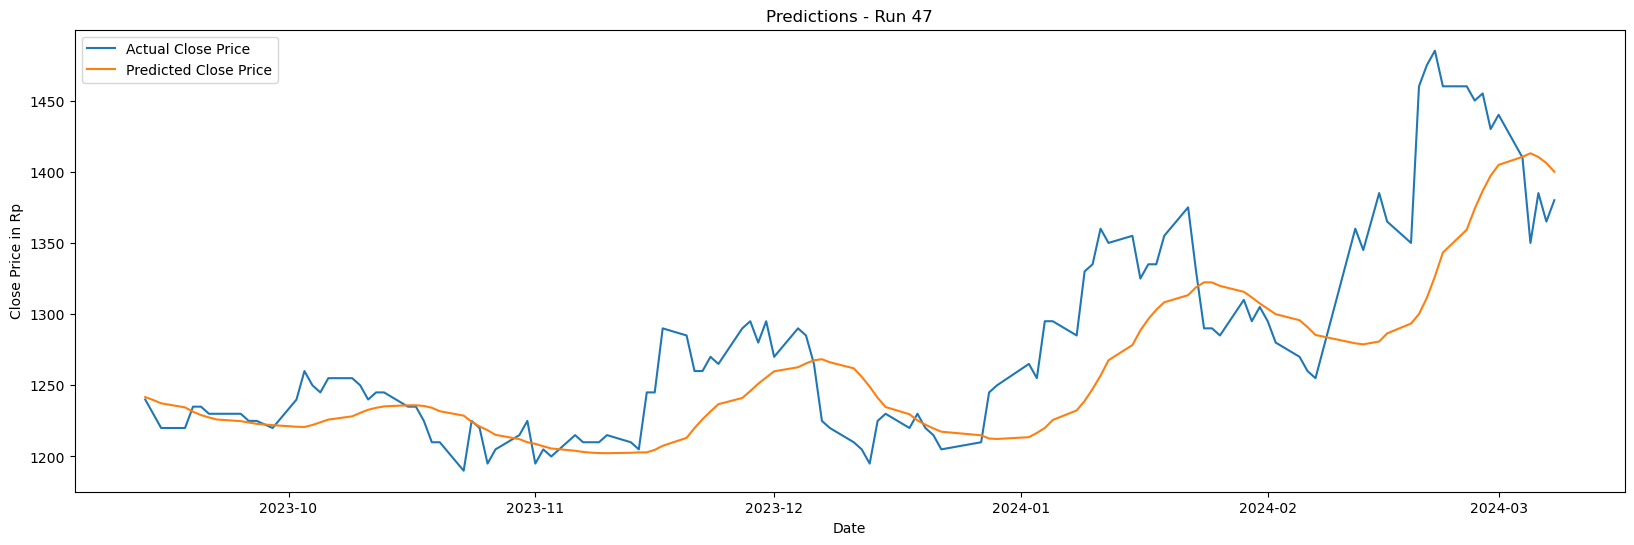

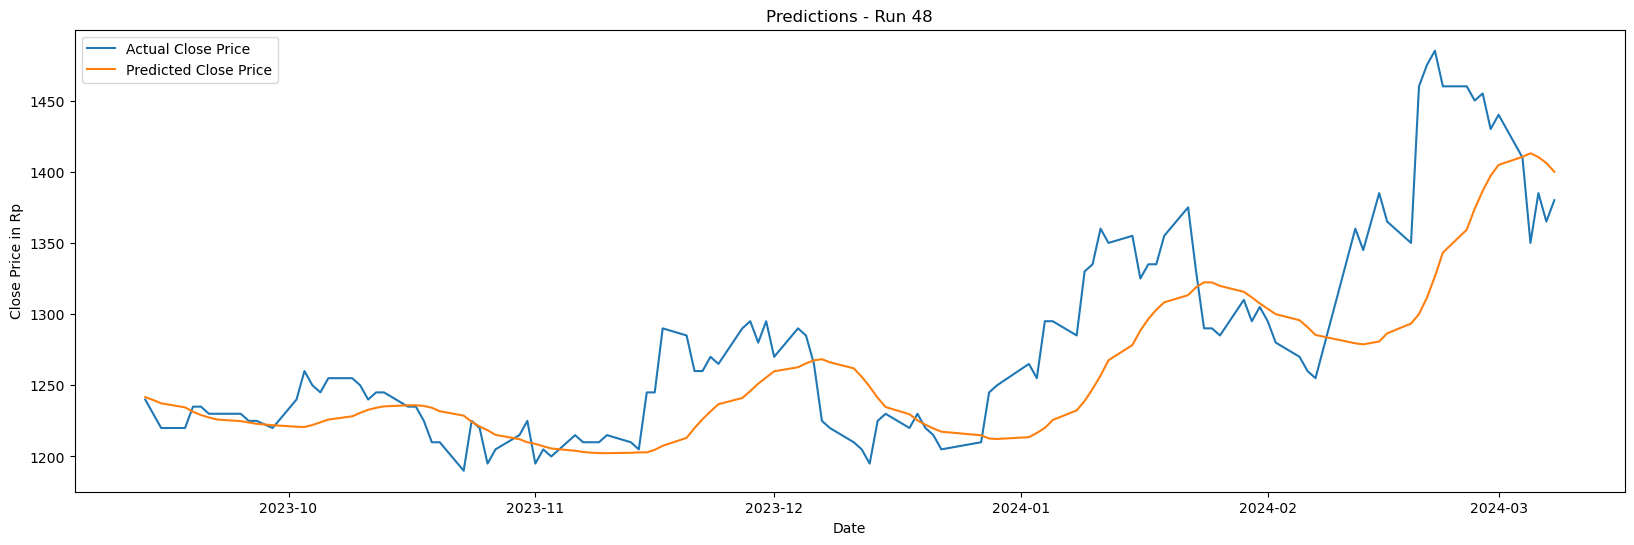

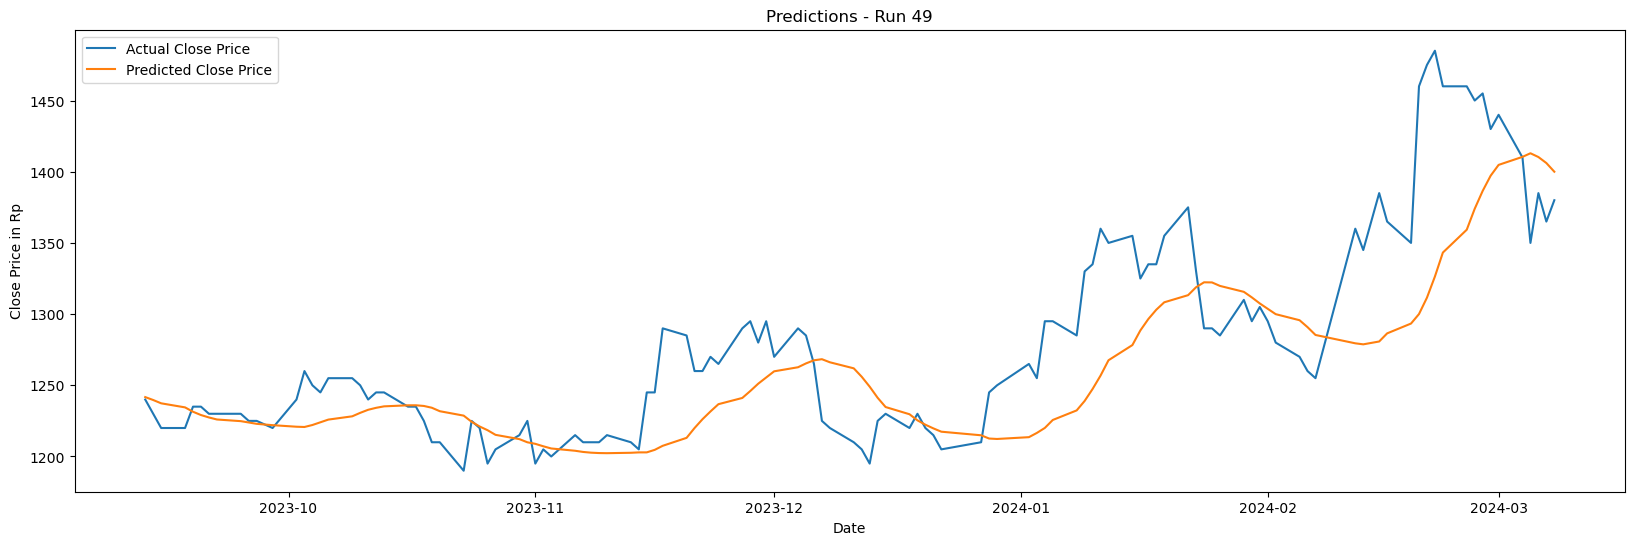

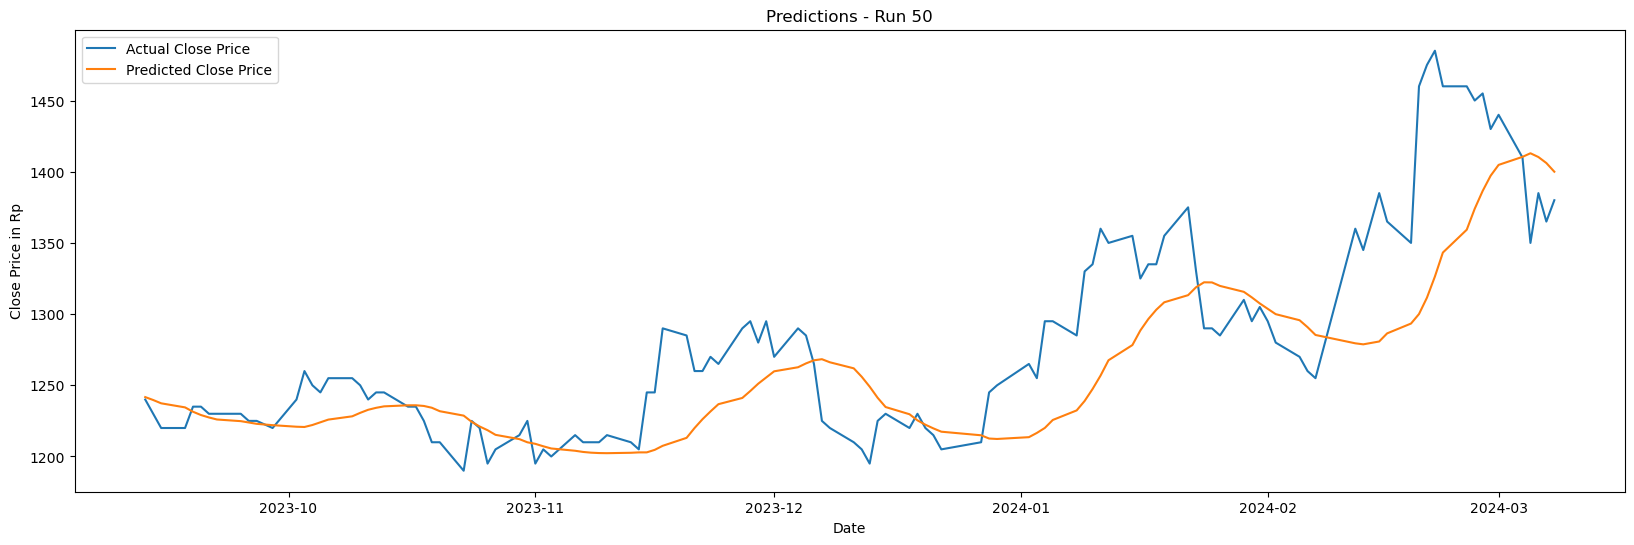

In [13]:
for i in range(50):
    # Plot predictions
    plt.figure(figsize=(20,6))
    plt.plot(data.index[training_data_len:], data['Close'][training_data_len:], label='Actual Close Price')
    plt.plot(data.index[training_data_len:], predictions, label='Predicted Close Price')
    plt.title(f'Predictions - Run {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price in Rp')
    plt.legend()
    plt.show()

In [14]:
# Ambil kolom 'Average_Prediction'
average_prediction = results_df['Average_Prediction'].copy()

# Hapus 2 baris terakhir dari 'average_prediction'
average_prediction = average_prediction.iloc[:-2]

# Buat DataFrame baru dengan kolom 'Average_Prediction'
new_dataframe = pd.DataFrame(average_prediction, columns=['Average_Prediction'])

# Atur kolom 'Date' dari data sebagai indeks
new_dataframe.index = data.index[training_data_len:]

# Tambahkan kolom 'Actual' dari data asli
new_dataframe['Actual'] = data['Close'][training_data_len:]  

# Tampilkan DataFrame baru
print(new_dataframe)

            Average_Prediction  Actual
Date                                  
2023-09-13         1241.310444  1240.0
2023-09-14         1239.329097  1230.0
2023-09-15         1237.090017  1220.0
2023-09-18         1234.334814  1220.0
2023-09-19         1231.376997  1235.0
...                        ...     ...
2024-03-04         1403.449736  1410.0
2024-03-05         1405.801775  1350.0
2024-03-06         1403.222095  1385.0
2024-03-07         1399.128909  1365.0
2024-03-08         1393.270051  1380.0

[121 rows x 2 columns]


In [15]:
# Save DataFrame to CSV with header
new_dataframe.to_csv('BBTNLSTMvsActualW100.csv', header=True)

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Fetch LSTM's Prediction (Average_Prediction) and the Actual data
predictions = new_dataframe['Average_Prediction']
actual = new_dataframe['Actual']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))

# Calculate MAPE
mape = calculate_mape(actual, predictions)

# Print RMSE & MAPE
print('RMSE:', rmse)
print('MAPE:', mape)

RMSE: 48.62294015839468
MAPE: 2.5771197530566186


/var/folders/dx/r9qzc02n76vb2zj4g6731w_r0000gn/T/ipykernel_41745/2582833144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


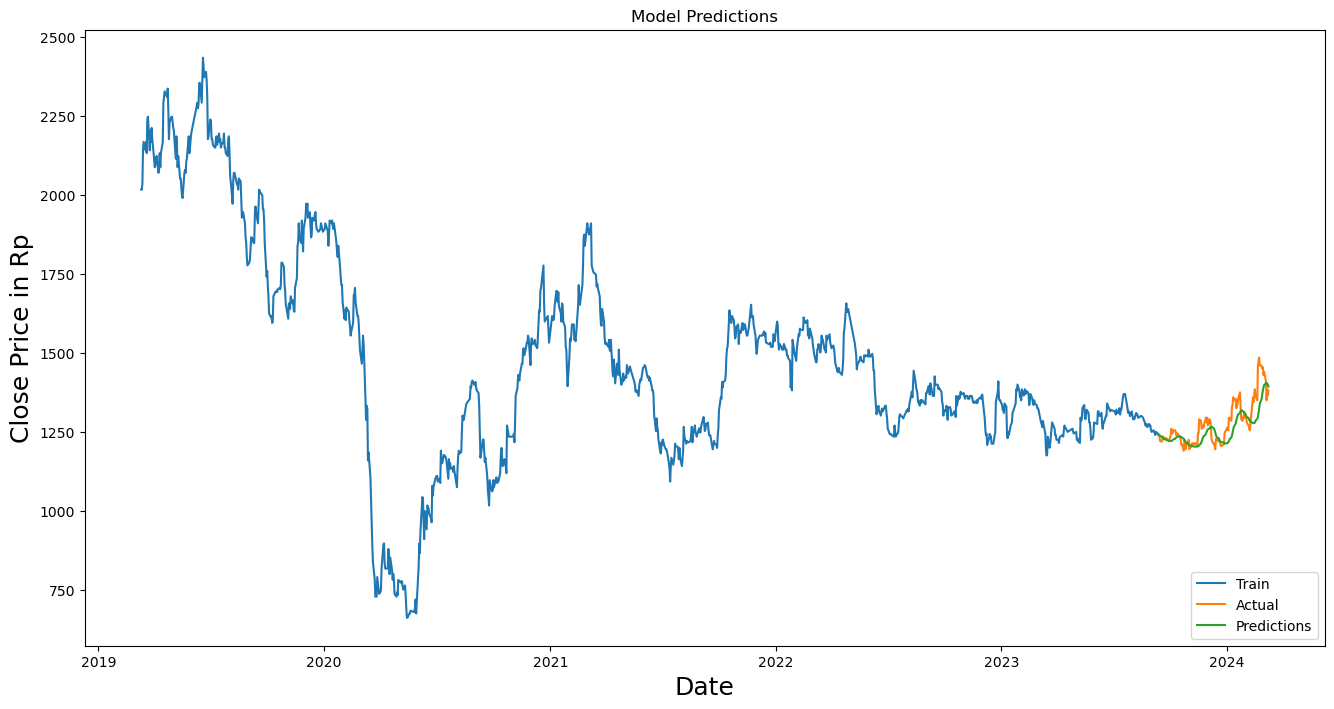

In [17]:
# Fetch testing and training data
train = data[:training_data_len]
valid = data[training_data_len:]

# Add 'Predictions'
valid['Predictions'] = predictions

# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual and prediction
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')

# Add legend
plt.legend(loc='lower right')
plt.show()

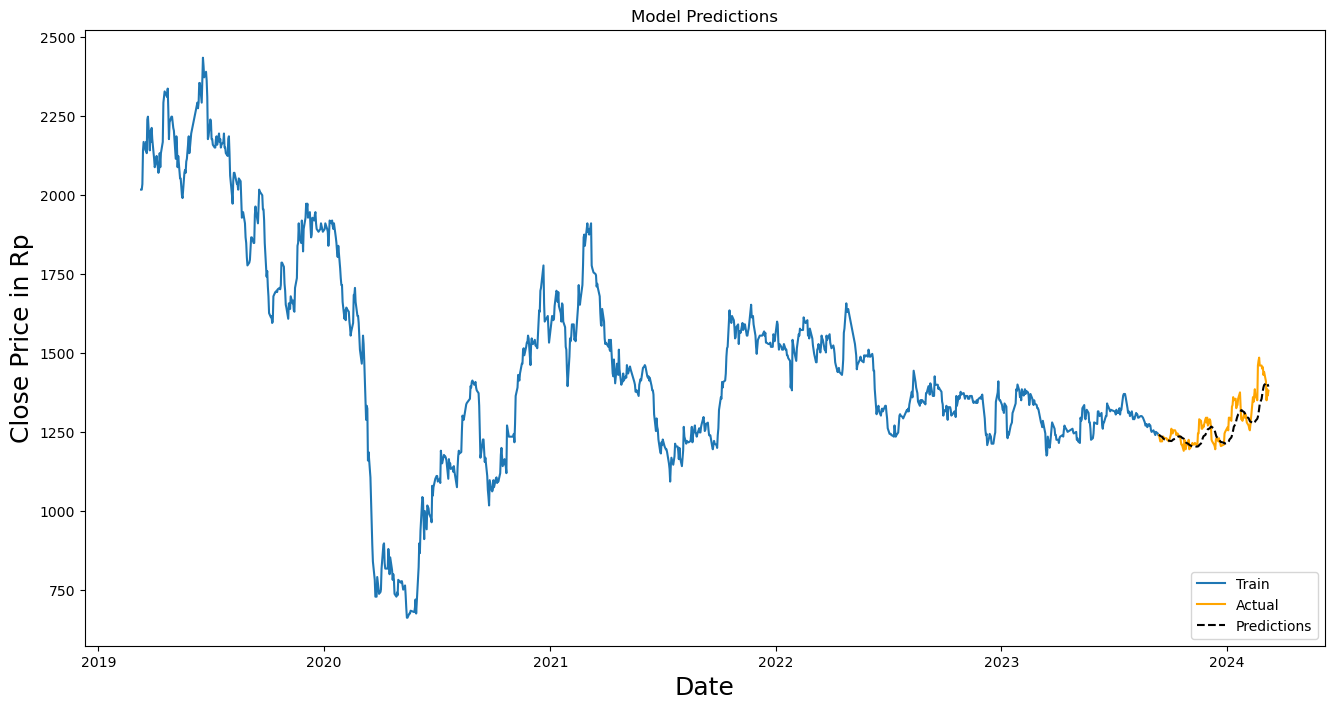

In [18]:
# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual data
plt.plot(valid.index, valid['Close'], label='Actual', linestyle='-', color='orange')

# Plot prediction data
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', color='black')

# Add legend
plt.legend(loc='lower right')
plt.show()